In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
sys.path.append("../..")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
from pathlib import Path
import pickle
import timeit
#
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models
from dotted_dict import DottedDict
from tqdm import tqdm
import pprint
#
from csprites.datasets import ClassificationDataset
import utils
from backbone import get_backbone
from optimizer import get_optimizer
from sklearn.linear_model import LogisticRegression
from plot_utils import *
from eval_utils import load_data_tensors

# Settings

In [5]:
# linprob config
linprob_config = {
    'p_eval': 'eval',
    'p_eval_results': 'results_lr.pkl',
    'p_config': "linprob_config_lr.pkl",
    'p_results': 'results_lr.pkl',
    'p_acc_mat': 'accuracy_lr.png',
}
linprob_config = DottedDict(linprob_config)

In [7]:
p_experiments_base = Path("/mnt/experiments/csprites/single_csprites_64x64_n7_c32_a32_p30_s3_bg_inf_random_function_70000")
p_experiments = [
    # SUP
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[shape]',
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[scale]',
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[color]',
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[angle]',
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[py]',
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[px]',
    
    # ARCHITECTURE SEARCH
    p_experiments_base / 'BTwins_[FCN8i223o32_d_16]_2021-09-11_04-48-41',
    p_experiments_base / 'BTwins_[FCN8i223o32_d_32]_2021-09-11_03-59-30',
    p_experiments_base / 'BTwins_[FCN8i223o32_d_64]_2021-09-11_03-11-37',
    p_experiments_base / 'BTwins_[FCN8i223o32_d_128]_2021-09-11_02-22-23',
    p_experiments_base / 'BTwins_[FCN8i223o32_d_256]_2021-09-11_01-32-15',
    p_experiments_base / 'BTwins_[FCN16i223o64_d_16]_2021-09-11_00-41-44',
    p_experiments_base / 'BTwins_[FCN16i223o64_d_32]_2021-09-10_23-51-29',
    p_experiments_base / 'BTwins_[FCN16i223o64_d_64]_2021-09-10_23-01-29',
    p_experiments_base / 'BTwins_[FCN16i223o64_d_128]_2021-09-10_22-17-49',
    p_experiments_base / 'BTwins_[FCN16i223o64_d_256]_2021-09-10_21-34-28',
    p_experiments_base / 'BTwins_[FCN32i223o128_d_16]_2021-09-10_20-32-27',
    p_experiments_base / 'BTwins_[FCN32i223o128_d_32]_2021-09-10_19-29-52',
    p_experiments_base / 'BTwins_[FCN32i223o128_d_64]_2021-09-10_18-27-52',
    p_experiments_base / 'BTwins_[FCN32i223o128_d_128]_2021-09-10_17-25-13',
    p_experiments_base / 'BTwins_[FCN32i223o128_d_256]_2021-09-10_16-21-00',
    
    # AUGMENTATION
    p_experiments_base / 'AUG[stl_0_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-10_22-59-21',
    p_experiments_base / 'AUG[stl_0_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-10_23-46-54',
    p_experiments_base / 'AUG[stl_0_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_00-36-46',
    p_experiments_base / 'AUG[stl_0_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_01-26-18',
    p_experiments_base / 'AUG[stl_0_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_02-15-29',
    p_experiments_base / 'AUG[stl_1_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-04-49',
    p_experiments_base / 'AUG[stl_1_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-52-48',
    p_experiments_base / 'AUG[stl_1_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_04-43-28',
    p_experiments_base / 'AUG[stl_1_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_05-33-59',
    p_experiments_base / 'AUG[stl_1_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-15-44',
    p_experiments_base / 'AUG[stl_2_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-56-34',
    p_experiments_base / 'AUG[stl_2_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_07-37-11',
    p_experiments_base / 'AUG[stl_2_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-18-06',
    p_experiments_base / 'AUG[stl_2_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-58-56',
    p_experiments_base / 'AUG[stl_2_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_09-39-44',
    p_experiments_base / 'AUG[stl_3_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_10-20-56',
    p_experiments_base / 'AUG[stl_3_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-01-13',
    p_experiments_base / 'AUG[stl_3_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-42-15',
    p_experiments_base / 'AUG[stl_3_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_12-23-33',
    p_experiments_base / 'AUG[stl_3_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-04-30',
    p_experiments_base / 'AUG[stl_4_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-45-46',
    p_experiments_base / 'AUG[stl_4_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_14-26-14',
    p_experiments_base / 'AUG[stl_4_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-07-38',
    p_experiments_base / 'AUG[stl_4_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-48-38',
    p_experiments_base / 'AUG[stl_4_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_16-29-54',
    p_experiments_base / 'AUG[stl_5_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-10-53',
    p_experiments_base / 'AUG[stl_5_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-51-38',
    p_experiments_base / 'AUG[stl_5_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_18-32-48',
    p_experiments_base / 'AUG[stl_5_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-14-17',
    p_experiments_base / 'AUG[stl_5_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-55-23',
    p_experiments_base / 'AUG[stl_6_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_20-36-28',
    p_experiments_base / 'AUG[stl_6_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-17-08',
    p_experiments_base / 'AUG[stl_6_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-58-13',
    p_experiments_base / 'AUG[stl_6_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_22-39-31',
    p_experiments_base / 'AUG[stl_6_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_23-20-33',
    p_experiments_base / 'AUG[stl_7_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-01-52',
    p_experiments_base / 'AUG[stl_7_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-42-24',
    p_experiments_base / 'AUG[stl_7_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-12_01-23-55',
    p_experiments_base / 'AUG[stl_7_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-05-21',
    p_experiments_base / 'AUG[stl_7_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-46-29',
]
for p in p_experiments:
    if not p.exists():
        print(p)

[  1/366] shape      SUP_[FCN8i223o32_d128]_target_[shape]
   LINPROB: 0.980
[  2/366] scale      SUP_[FCN8i223o32_d128]_target_[shape]
   LINPROB: 0.637
[  3/366] color      SUP_[FCN8i223o32_d128]_target_[shape]
   LINPROB: 0.067
[  4/366] angle      SUP_[FCN8i223o32_d128]_target_[shape]
   LINPROB: 0.084
[  5/366] py         SUP_[FCN8i223o32_d128]_target_[shape]
   LINPROB: 0.218
[  6/366] px         SUP_[FCN8i223o32_d128]_target_[shape]
   LINPROB: 0.215


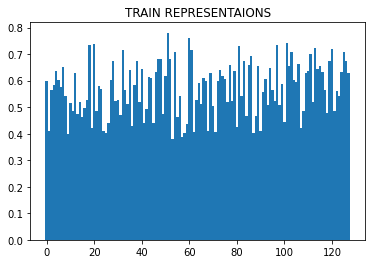

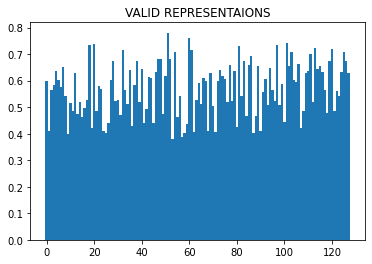

[  7/366] shape      SUP_[FCN8i223o32_d128]_target_[scale]
   LINPROB: 0.489
[  8/366] scale      SUP_[FCN8i223o32_d128]_target_[scale]
   LINPROB: 0.957
[  9/366] color      SUP_[FCN8i223o32_d128]_target_[scale]
   LINPROB: 0.088
[ 10/366] angle      SUP_[FCN8i223o32_d128]_target_[scale]
   LINPROB: 0.058
[ 11/366] py         SUP_[FCN8i223o32_d128]_target_[scale]
   LINPROB: 0.257
[ 12/366] px         SUP_[FCN8i223o32_d128]_target_[scale]
   LINPROB: 0.244


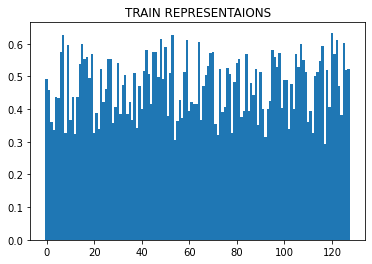

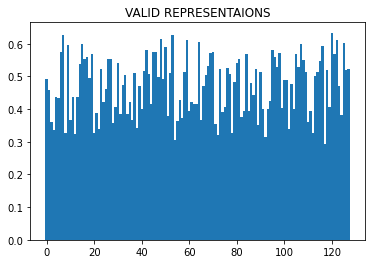

[ 13/366] shape      SUP_[FCN8i223o32_d128]_target_[color]
   LINPROB: 0.272
[ 14/366] scale      SUP_[FCN8i223o32_d128]_target_[color]
   LINPROB: 0.468
[ 15/366] color      SUP_[FCN8i223o32_d128]_target_[color]
   LINPROB: 0.984
[ 16/366] angle      SUP_[FCN8i223o32_d128]_target_[color]
   LINPROB: 0.038
[ 17/366] py         SUP_[FCN8i223o32_d128]_target_[color]
   LINPROB: 0.108
[ 18/366] px         SUP_[FCN8i223o32_d128]_target_[color]
   LINPROB: 0.100


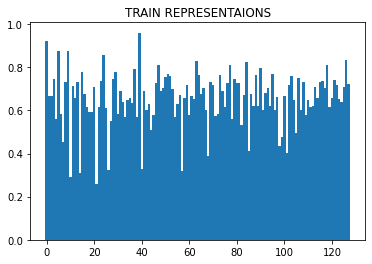

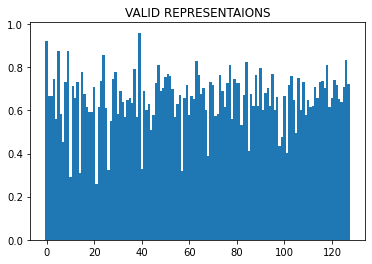

[ 19/366] shape      SUP_[FCN8i223o32_d128]_target_[angle]
   LINPROB: 0.894
[ 20/366] scale      SUP_[FCN8i223o32_d128]_target_[angle]
   LINPROB: 0.487
[ 21/366] color      SUP_[FCN8i223o32_d128]_target_[angle]
   LINPROB: 0.061
[ 22/366] angle      SUP_[FCN8i223o32_d128]_target_[angle]
   LINPROB: 0.614
[ 23/366] py         SUP_[FCN8i223o32_d128]_target_[angle]
   LINPROB: 0.121
[ 24/366] px         SUP_[FCN8i223o32_d128]_target_[angle]
   LINPROB: 0.142


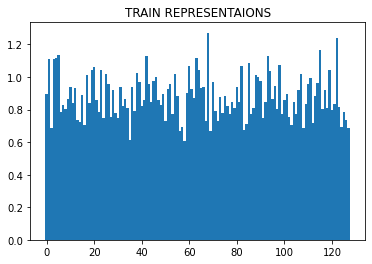

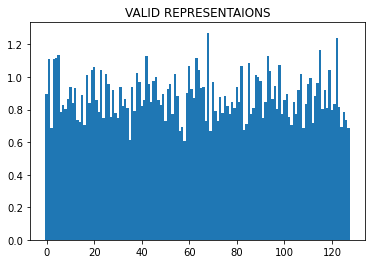

[ 25/366] shape      SUP_[FCN8i223o32_d128]_target_[py]
   LINPROB: 0.504
[ 26/366] scale      SUP_[FCN8i223o32_d128]_target_[py]
   LINPROB: 0.499
[ 27/366] color      SUP_[FCN8i223o32_d128]_target_[py]
   LINPROB: 0.074
[ 28/366] angle      SUP_[FCN8i223o32_d128]_target_[py]
   LINPROB: 0.082
[ 29/366] py         SUP_[FCN8i223o32_d128]_target_[py]
   LINPROB: 0.924
[ 30/366] px         SUP_[FCN8i223o32_d128]_target_[py]
   LINPROB: 0.110


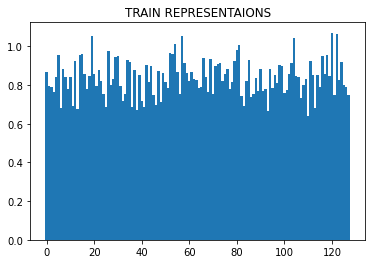

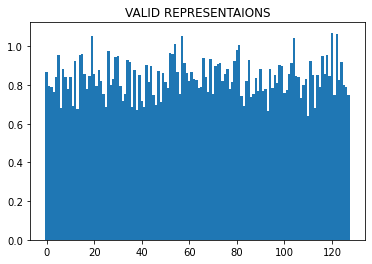

[ 31/366] shape      SUP_[FCN8i223o32_d128]_target_[px]
   LINPROB: 0.472
[ 32/366] scale      SUP_[FCN8i223o32_d128]_target_[px]
   LINPROB: 0.487
[ 33/366] color      SUP_[FCN8i223o32_d128]_target_[px]
   LINPROB: 0.086
[ 34/366] angle      SUP_[FCN8i223o32_d128]_target_[px]
   LINPROB: 0.085
[ 35/366] py         SUP_[FCN8i223o32_d128]_target_[px]
   LINPROB: 0.106
[ 36/366] px         SUP_[FCN8i223o32_d128]_target_[px]
   LINPROB: 0.938


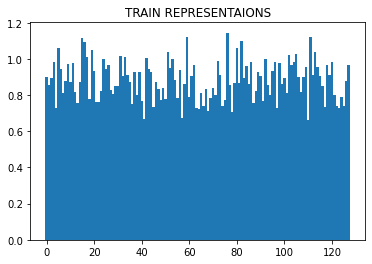

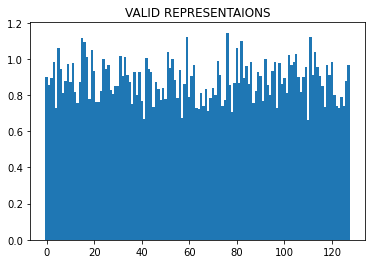

[ 37/366] shape      BTwins_[FCN8i223o32_d_16]_2021-09-11_04-48-41
   LINPROB: 0.412
[ 38/366] scale      BTwins_[FCN8i223o32_d_16]_2021-09-11_04-48-41
   LINPROB: 0.382
[ 39/366] color      BTwins_[FCN8i223o32_d_16]_2021-09-11_04-48-41
   LINPROB: 0.042
[ 40/366] angle      BTwins_[FCN8i223o32_d_16]_2021-09-11_04-48-41
   LINPROB: 0.059
[ 41/366] py         BTwins_[FCN8i223o32_d_16]_2021-09-11_04-48-41
   LINPROB: 0.127
[ 42/366] px         BTwins_[FCN8i223o32_d_16]_2021-09-11_04-48-41
   LINPROB: 0.041


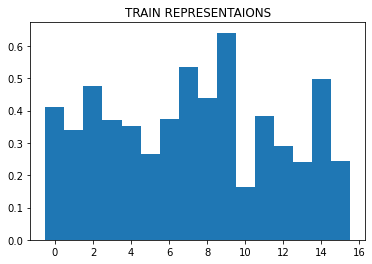

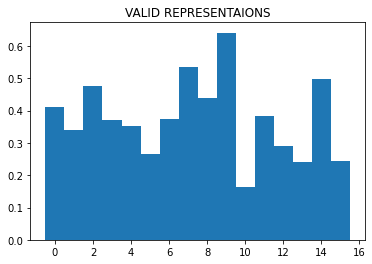

[ 43/366] shape      BTwins_[FCN8i223o32_d_32]_2021-09-11_03-59-30
   LINPROB: 0.693
[ 44/366] scale      BTwins_[FCN8i223o32_d_32]_2021-09-11_03-59-30
   LINPROB: 0.413
[ 45/366] color      BTwins_[FCN8i223o32_d_32]_2021-09-11_03-59-30
   LINPROB: 0.043
[ 46/366] angle      BTwins_[FCN8i223o32_d_32]_2021-09-11_03-59-30
   LINPROB: 0.135
[ 47/366] py         BTwins_[FCN8i223o32_d_32]_2021-09-11_03-59-30
   LINPROB: 0.181
[ 48/366] px         BTwins_[FCN8i223o32_d_32]_2021-09-11_03-59-30
   LINPROB: 0.048


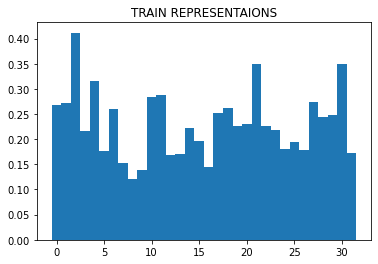

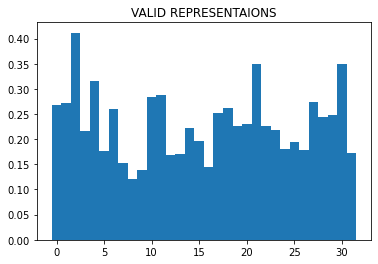

[ 49/366] shape      BTwins_[FCN8i223o32_d_64]_2021-09-11_03-11-37
   LINPROB: 0.853
[ 50/366] scale      BTwins_[FCN8i223o32_d_64]_2021-09-11_03-11-37
   LINPROB: 0.505
[ 51/366] color      BTwins_[FCN8i223o32_d_64]_2021-09-11_03-11-37
   LINPROB: 0.054
[ 52/366] angle      BTwins_[FCN8i223o32_d_64]_2021-09-11_03-11-37
   LINPROB: 0.251
[ 53/366] py         BTwins_[FCN8i223o32_d_64]_2021-09-11_03-11-37
   LINPROB: 0.239
[ 54/366] px         BTwins_[FCN8i223o32_d_64]_2021-09-11_03-11-37
   LINPROB: 0.077


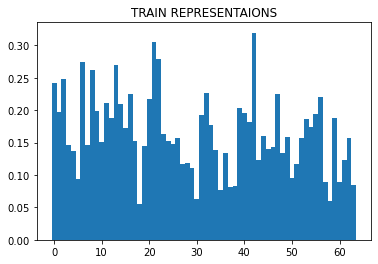

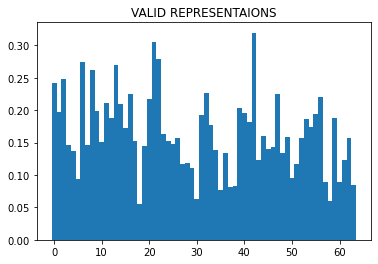

[ 55/366] shape      BTwins_[FCN8i223o32_d_128]_2021-09-11_02-22-23
   LINPROB: 0.930
[ 56/366] scale      BTwins_[FCN8i223o32_d_128]_2021-09-11_02-22-23
   LINPROB: 0.647
[ 57/366] color      BTwins_[FCN8i223o32_d_128]_2021-09-11_02-22-23
   LINPROB: 0.069
[ 58/366] angle      BTwins_[FCN8i223o32_d_128]_2021-09-11_02-22-23
   LINPROB: 0.355
[ 59/366] py         BTwins_[FCN8i223o32_d_128]_2021-09-11_02-22-23
   LINPROB: 0.323
[ 60/366] px         BTwins_[FCN8i223o32_d_128]_2021-09-11_02-22-23
   LINPROB: 0.174


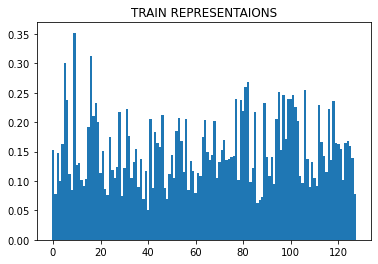

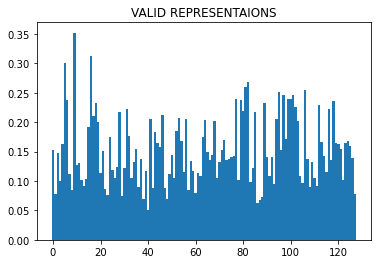

[ 61/366] shape      BTwins_[FCN8i223o32_d_256]_2021-09-11_01-32-15
   LINPROB: 0.940
[ 62/366] scale      BTwins_[FCN8i223o32_d_256]_2021-09-11_01-32-15
   LINPROB: 0.742
[ 63/366] color      BTwins_[FCN8i223o32_d_256]_2021-09-11_01-32-15
   LINPROB: 0.100
[ 64/366] angle      BTwins_[FCN8i223o32_d_256]_2021-09-11_01-32-15
   LINPROB: 0.403
[ 65/366] py         BTwins_[FCN8i223o32_d_256]_2021-09-11_01-32-15
   LINPROB: 0.435
[ 66/366] px         BTwins_[FCN8i223o32_d_256]_2021-09-11_01-32-15
   LINPROB: 0.293


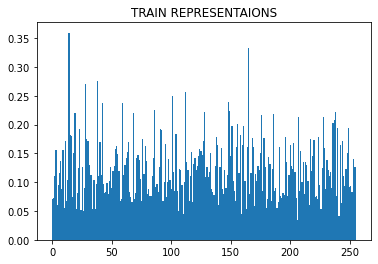

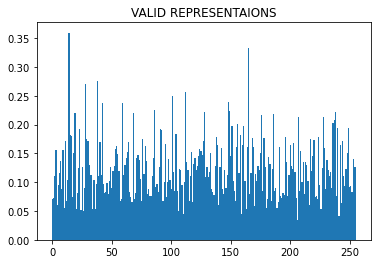

[ 67/366] shape      BTwins_[FCN16i223o64_d_16]_2021-09-11_00-41-44
   LINPROB: 0.413
[ 68/366] scale      BTwins_[FCN16i223o64_d_16]_2021-09-11_00-41-44
   LINPROB: 0.371
[ 69/366] color      BTwins_[FCN16i223o64_d_16]_2021-09-11_00-41-44
   LINPROB: 0.037
[ 70/366] angle      BTwins_[FCN16i223o64_d_16]_2021-09-11_00-41-44
   LINPROB: 0.069
[ 71/366] py         BTwins_[FCN16i223o64_d_16]_2021-09-11_00-41-44
   LINPROB: 0.078
[ 72/366] px         BTwins_[FCN16i223o64_d_16]_2021-09-11_00-41-44
   LINPROB: 0.040


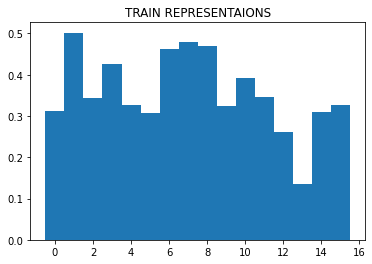

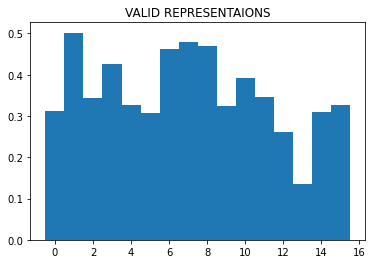

[ 73/366] shape      BTwins_[FCN16i223o64_d_32]_2021-09-10_23-51-29
   LINPROB: 0.672
[ 74/366] scale      BTwins_[FCN16i223o64_d_32]_2021-09-10_23-51-29
   LINPROB: 0.400
[ 75/366] color      BTwins_[FCN16i223o64_d_32]_2021-09-10_23-51-29
   LINPROB: 0.046
[ 76/366] angle      BTwins_[FCN16i223o64_d_32]_2021-09-10_23-51-29
   LINPROB: 0.126
[ 77/366] py         BTwins_[FCN16i223o64_d_32]_2021-09-10_23-51-29
   LINPROB: 0.141
[ 78/366] px         BTwins_[FCN16i223o64_d_32]_2021-09-10_23-51-29
   LINPROB: 0.047


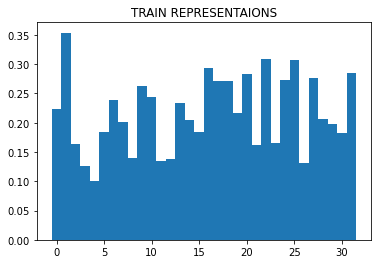

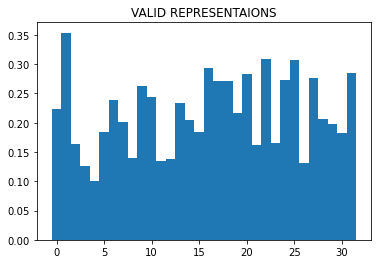

[ 79/366] shape      BTwins_[FCN16i223o64_d_64]_2021-09-10_23-01-29
   LINPROB: 0.926
[ 80/366] scale      BTwins_[FCN16i223o64_d_64]_2021-09-10_23-01-29
   LINPROB: 0.506
[ 81/366] color      BTwins_[FCN16i223o64_d_64]_2021-09-10_23-01-29
   LINPROB: 0.051
[ 82/366] angle      BTwins_[FCN16i223o64_d_64]_2021-09-10_23-01-29
   LINPROB: 0.307
[ 83/366] py         BTwins_[FCN16i223o64_d_64]_2021-09-10_23-01-29
   LINPROB: 0.205
[ 84/366] px         BTwins_[FCN16i223o64_d_64]_2021-09-10_23-01-29
   LINPROB: 0.065


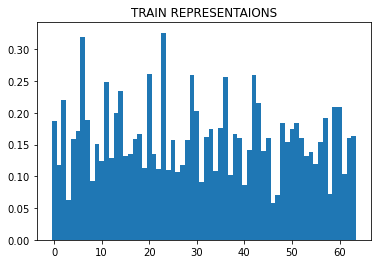

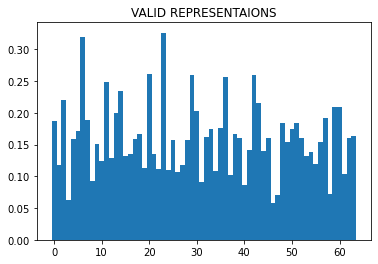

[ 85/366] shape      BTwins_[FCN16i223o64_d_128]_2021-09-10_22-17-49
   LINPROB: 0.985
[ 86/366] scale      BTwins_[FCN16i223o64_d_128]_2021-09-10_22-17-49
   LINPROB: 0.638
[ 87/366] color      BTwins_[FCN16i223o64_d_128]_2021-09-10_22-17-49
   LINPROB: 0.069
[ 88/366] angle      BTwins_[FCN16i223o64_d_128]_2021-09-10_22-17-49
   LINPROB: 0.406
[ 89/366] py         BTwins_[FCN16i223o64_d_128]_2021-09-10_22-17-49
   LINPROB: 0.266
[ 90/366] px         BTwins_[FCN16i223o64_d_128]_2021-09-10_22-17-49
   LINPROB: 0.109


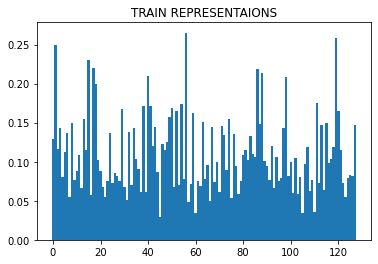

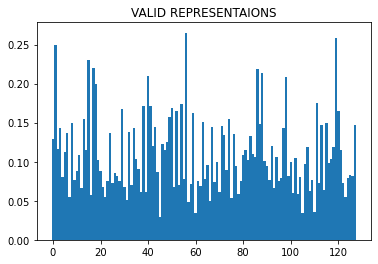

[ 91/366] shape      BTwins_[FCN16i223o64_d_256]_2021-09-10_21-34-28
   LINPROB: 0.991
[ 92/366] scale      BTwins_[FCN16i223o64_d_256]_2021-09-10_21-34-28
   LINPROB: 0.799
[ 93/366] color      BTwins_[FCN16i223o64_d_256]_2021-09-10_21-34-28
   LINPROB: 0.093
[ 94/366] angle      BTwins_[FCN16i223o64_d_256]_2021-09-10_21-34-28
   LINPROB: 0.479
[ 95/366] py         BTwins_[FCN16i223o64_d_256]_2021-09-10_21-34-28
   LINPROB: 0.397
[ 96/366] px         BTwins_[FCN16i223o64_d_256]_2021-09-10_21-34-28
   LINPROB: 0.204


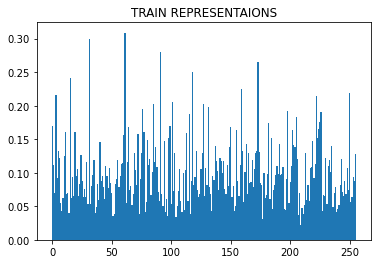

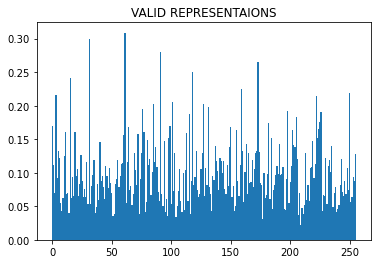

[ 97/366] shape      BTwins_[FCN32i223o128_d_16]_2021-09-10_20-32-27
   LINPROB: 0.409
[ 98/366] scale      BTwins_[FCN32i223o128_d_16]_2021-09-10_20-32-27
   LINPROB: 0.358
[ 99/366] color      BTwins_[FCN32i223o128_d_16]_2021-09-10_20-32-27
   LINPROB: 0.039
[100/366] angle      BTwins_[FCN32i223o128_d_16]_2021-09-10_20-32-27
   LINPROB: 0.067
[101/366] py         BTwins_[FCN32i223o128_d_16]_2021-09-10_20-32-27
   LINPROB: 0.055
[102/366] px         BTwins_[FCN32i223o128_d_16]_2021-09-10_20-32-27
   LINPROB: 0.040


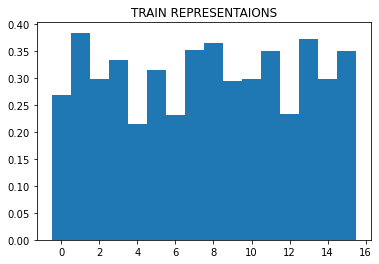

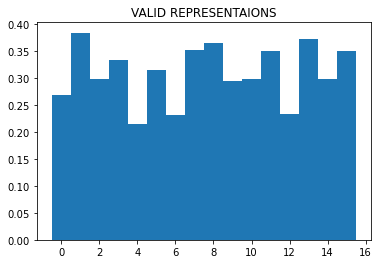

[103/366] shape      BTwins_[FCN32i223o128_d_32]_2021-09-10_19-29-52
   LINPROB: 0.687
[104/366] scale      BTwins_[FCN32i223o128_d_32]_2021-09-10_19-29-52
   LINPROB: 0.371
[105/366] color      BTwins_[FCN32i223o128_d_32]_2021-09-10_19-29-52
   LINPROB: 0.041
[106/366] angle      BTwins_[FCN32i223o128_d_32]_2021-09-10_19-29-52
   LINPROB: 0.128
[107/366] py         BTwins_[FCN32i223o128_d_32]_2021-09-10_19-29-52
   LINPROB: 0.074
[108/366] px         BTwins_[FCN32i223o128_d_32]_2021-09-10_19-29-52
   LINPROB: 0.046


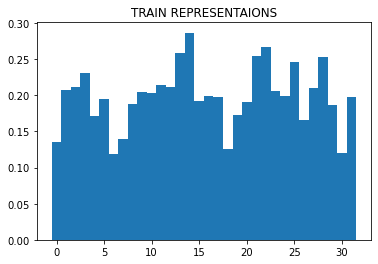

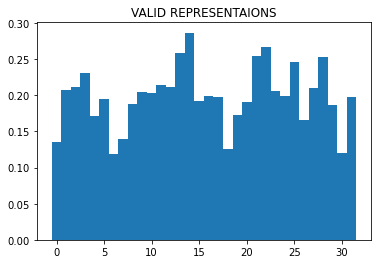

[109/366] shape      BTwins_[FCN32i223o128_d_64]_2021-09-10_18-27-52
   LINPROB: 0.976
[110/366] scale      BTwins_[FCN32i223o128_d_64]_2021-09-10_18-27-52
   LINPROB: 0.409
[111/366] color      BTwins_[FCN32i223o128_d_64]_2021-09-10_18-27-52
   LINPROB: 0.047
[112/366] angle      BTwins_[FCN32i223o128_d_64]_2021-09-10_18-27-52
   LINPROB: 0.315
[113/366] py         BTwins_[FCN32i223o128_d_64]_2021-09-10_18-27-52
   LINPROB: 0.094
[114/366] px         BTwins_[FCN32i223o128_d_64]_2021-09-10_18-27-52
   LINPROB: 0.053


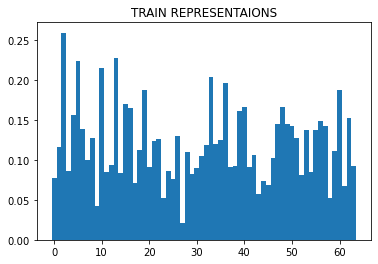

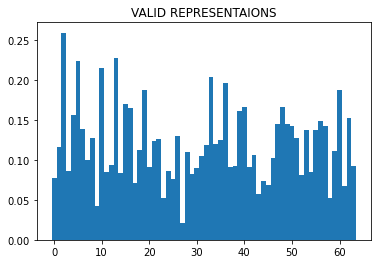

[115/366] shape      BTwins_[FCN32i223o128_d_128]_2021-09-10_17-25-13
   LINPROB: 0.998
[116/366] scale      BTwins_[FCN32i223o128_d_128]_2021-09-10_17-25-13
   LINPROB: 0.549
[117/366] color      BTwins_[FCN32i223o128_d_128]_2021-09-10_17-25-13
   LINPROB: 0.059
[118/366] angle      BTwins_[FCN32i223o128_d_128]_2021-09-10_17-25-13
   LINPROB: 0.458
[119/366] py         BTwins_[FCN32i223o128_d_128]_2021-09-10_17-25-13
   LINPROB: 0.180
[120/366] px         BTwins_[FCN32i223o128_d_128]_2021-09-10_17-25-13
   LINPROB: 0.080


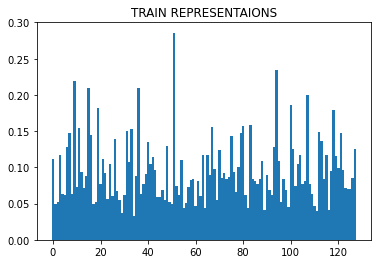

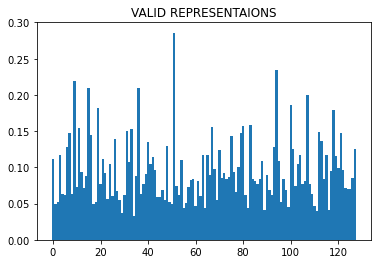

[121/366] shape      BTwins_[FCN32i223o128_d_256]_2021-09-10_16-21-00
   LINPROB: 0.998
[122/366] scale      BTwins_[FCN32i223o128_d_256]_2021-09-10_16-21-00
   LINPROB: 0.780
[123/366] color      BTwins_[FCN32i223o128_d_256]_2021-09-10_16-21-00
   LINPROB: 0.096
[124/366] angle      BTwins_[FCN32i223o128_d_256]_2021-09-10_16-21-00
   LINPROB: 0.497
[125/366] py         BTwins_[FCN32i223o128_d_256]_2021-09-10_16-21-00
   LINPROB: 0.338
[126/366] px         BTwins_[FCN32i223o128_d_256]_2021-09-10_16-21-00
   LINPROB: 0.163


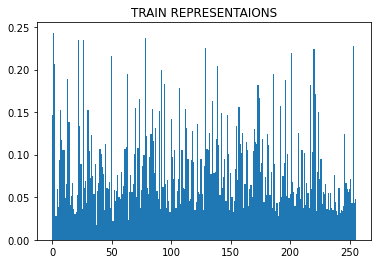

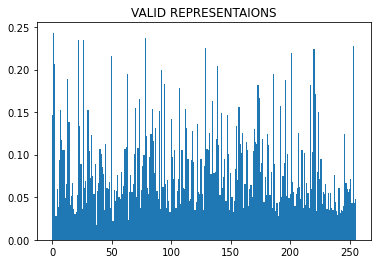

[127/366] shape      AUG[stl_0_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-10_22-59-21
   LINPROB: 0.392
[128/366] scale      AUG[stl_0_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-10_22-59-21
   LINPROB: 0.429
[129/366] color      AUG[stl_0_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-10_22-59-21
   LINPROB: 0.076
[130/366] angle      AUG[stl_0_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-10_22-59-21
   LINPROB: 0.060
[131/366] py         AUG[stl_0_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-10_22-59-21
   LINPROB: 0.326
[132/366] px         AUG[stl_0_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-10_22-59-21
   LINPROB: 0.291


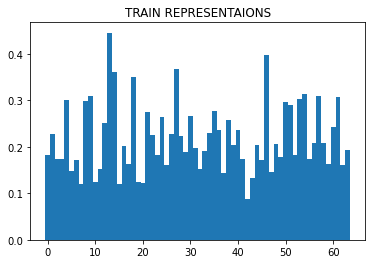

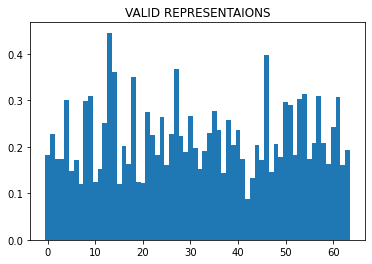

[133/366] shape      AUG[stl_0_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-10_23-46-54
   LINPROB: 0.560
[134/366] scale      AUG[stl_0_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-10_23-46-54
   LINPROB: 0.500
[135/366] color      AUG[stl_0_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-10_23-46-54
   LINPROB: 0.153
[136/366] angle      AUG[stl_0_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-10_23-46-54
   LINPROB: 0.081
[137/366] py         AUG[stl_0_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-10_23-46-54
   LINPROB: 0.072
[138/366] px         AUG[stl_0_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-10_23-46-54
   LINPROB: 0.072


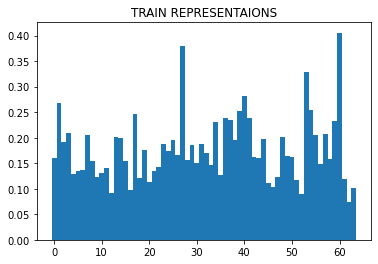

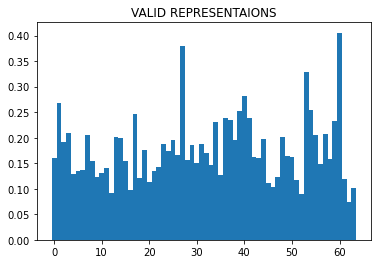

[139/366] shape      AUG[stl_0_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_00-36-46
   LINPROB: 0.554
[140/366] scale      AUG[stl_0_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_00-36-46
   LINPROB: 0.462
[141/366] color      AUG[stl_0_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_00-36-46
   LINPROB: 0.188
[142/366] angle      AUG[stl_0_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_00-36-46
   LINPROB: 0.088
[143/366] py         AUG[stl_0_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_00-36-46
   LINPROB: 0.059
[144/366] px         AUG[stl_0_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_00-36-46
   LINPROB: 0.058


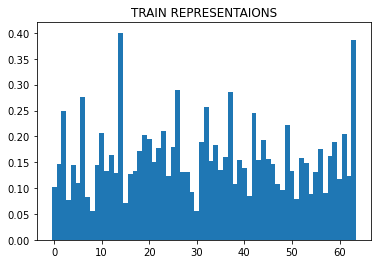

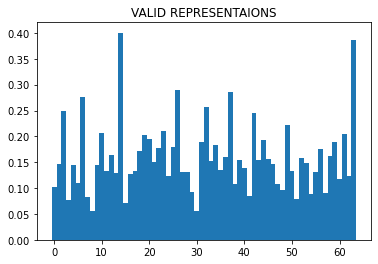

[145/366] shape      AUG[stl_0_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_01-26-18
   LINPROB: 0.662
[146/366] scale      AUG[stl_0_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_01-26-18
   LINPROB: 0.459
[147/366] color      AUG[stl_0_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_01-26-18
   LINPROB: 0.263
[148/366] angle      AUG[stl_0_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_01-26-18
   LINPROB: 0.089
[149/366] py         AUG[stl_0_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_01-26-18
   LINPROB: 0.059
[150/366] px         AUG[stl_0_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_01-26-18
   LINPROB: 0.059


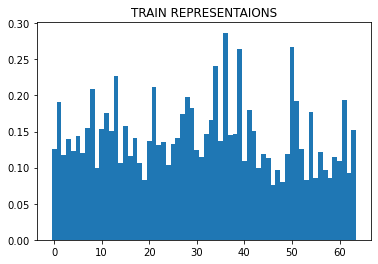

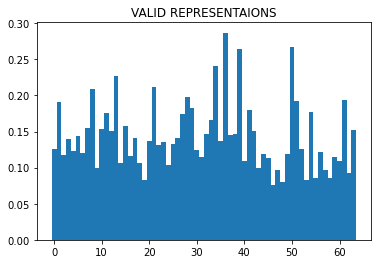

[151/366] shape      AUG[stl_0_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_02-15-29
   LINPROB: 0.600
[152/366] scale      AUG[stl_0_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_02-15-29
   LINPROB: 0.447
[153/366] color      AUG[stl_0_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_02-15-29
   LINPROB: 0.288
[154/366] angle      AUG[stl_0_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_02-15-29
   LINPROB: 0.086
[155/366] py         AUG[stl_0_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_02-15-29
   LINPROB: 0.059
[156/366] px         AUG[stl_0_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_02-15-29
   LINPROB: 0.059


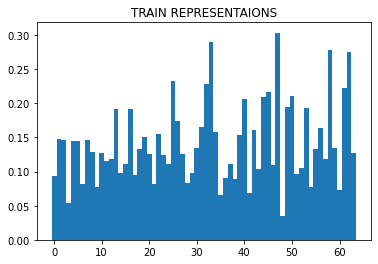

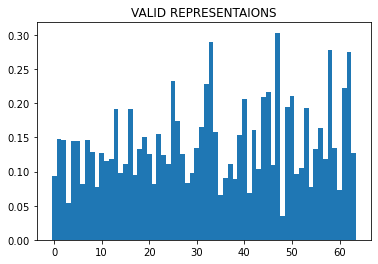

[157/366] shape      AUG[stl_1_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-04-49
   LINPROB: 0.446
[158/366] scale      AUG[stl_1_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-04-49
   LINPROB: 0.463
[159/366] color      AUG[stl_1_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-04-49
   LINPROB: 0.058
[160/366] angle      AUG[stl_1_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-04-49
   LINPROB: 0.068
[161/366] py         AUG[stl_1_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-04-49
   LINPROB: 0.333
[162/366] px         AUG[stl_1_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-04-49
   LINPROB: 0.324


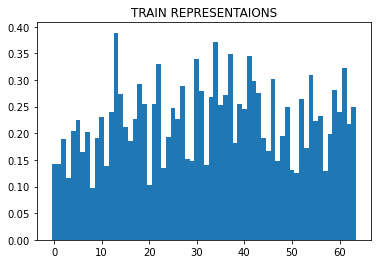

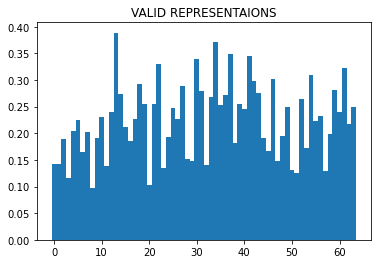

[163/366] shape      AUG[stl_1_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-52-48
   LINPROB: 0.843
[164/366] scale      AUG[stl_1_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-52-48
   LINPROB: 0.503
[165/366] color      AUG[stl_1_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-52-48
   LINPROB: 0.083
[166/366] angle      AUG[stl_1_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-52-48
   LINPROB: 0.128
[167/366] py         AUG[stl_1_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-52-48
   LINPROB: 0.083
[168/366] px         AUG[stl_1_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-52-48
   LINPROB: 0.091


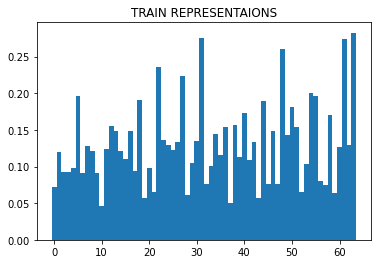

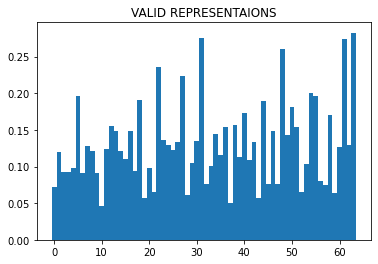

[169/366] shape      AUG[stl_1_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_04-43-28
   LINPROB: 0.788
[170/366] scale      AUG[stl_1_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_04-43-28
   LINPROB: 0.509
[171/366] color      AUG[stl_1_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_04-43-28
   LINPROB: 0.087
[172/366] angle      AUG[stl_1_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_04-43-28
   LINPROB: 0.123
[173/366] py         AUG[stl_1_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_04-43-28
   LINPROB: 0.068
[174/366] px         AUG[stl_1_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_04-43-28
   LINPROB: 0.063


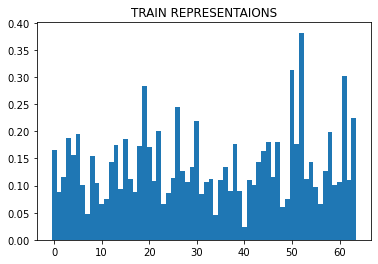

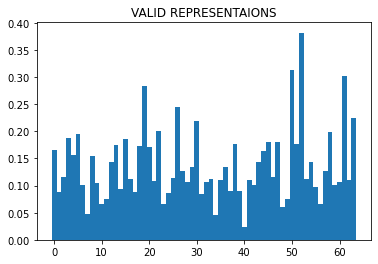

[175/366] shape      AUG[stl_1_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_05-33-59
   LINPROB: 0.811
[176/366] scale      AUG[stl_1_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_05-33-59
   LINPROB: 0.503
[177/366] color      AUG[stl_1_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_05-33-59
   LINPROB: 0.097
[178/366] angle      AUG[stl_1_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_05-33-59
   LINPROB: 0.120
[179/366] py         AUG[stl_1_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_05-33-59
   LINPROB: 0.065
[180/366] px         AUG[stl_1_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_05-33-59
   LINPROB: 0.061


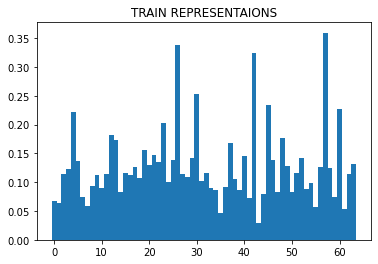

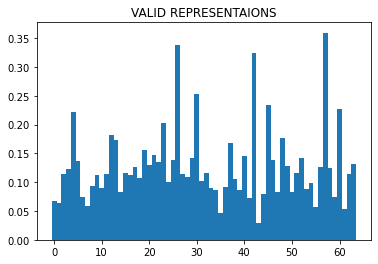

[181/366] shape      AUG[stl_1_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-15-44
   LINPROB: 0.857
[182/366] scale      AUG[stl_1_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-15-44
   LINPROB: 0.485
[183/366] color      AUG[stl_1_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-15-44
   LINPROB: 0.089
[184/366] angle      AUG[stl_1_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-15-44
   LINPROB: 0.145
[185/366] py         AUG[stl_1_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-15-44
   LINPROB: 0.058
[186/366] px         AUG[stl_1_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-15-44
   LINPROB: 0.063


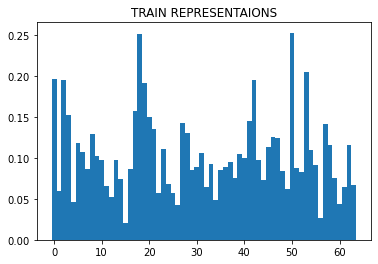

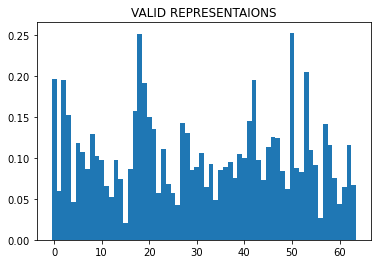

[187/366] shape      AUG[stl_2_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-56-34
   LINPROB: 0.453
[188/366] scale      AUG[stl_2_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-56-34
   LINPROB: 0.459
[189/366] color      AUG[stl_2_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-56-34
   LINPROB: 0.058
[190/366] angle      AUG[stl_2_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-56-34
   LINPROB: 0.069
[191/366] py         AUG[stl_2_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-56-34
   LINPROB: 0.344
[192/366] px         AUG[stl_2_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-56-34
   LINPROB: 0.354


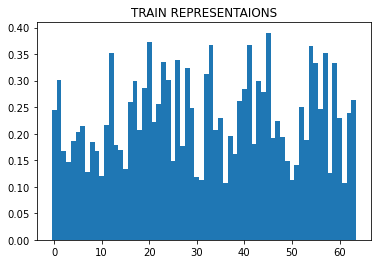

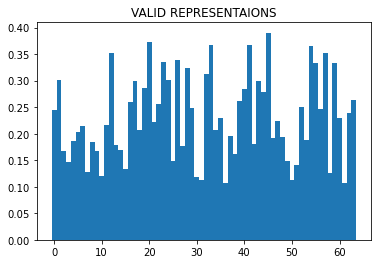

[193/366] shape      AUG[stl_2_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_07-37-11
   LINPROB: 0.872
[194/366] scale      AUG[stl_2_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_07-37-11
   LINPROB: 0.570
[195/366] color      AUG[stl_2_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_07-37-11
   LINPROB: 0.082
[196/366] angle      AUG[stl_2_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_07-37-11
   LINPROB: 0.142
[197/366] py         AUG[stl_2_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_07-37-11
   LINPROB: 0.114
[198/366] px         AUG[stl_2_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_07-37-11
   LINPROB: 0.114


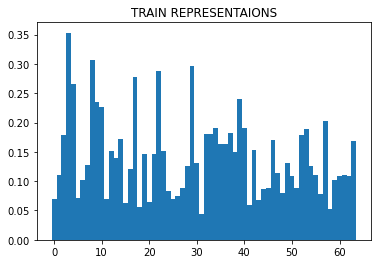

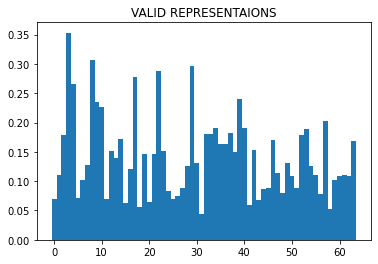

[199/366] shape      AUG[stl_2_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-18-06
   LINPROB: 0.893
[200/366] scale      AUG[stl_2_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-18-06
   LINPROB: 0.525
[201/366] color      AUG[stl_2_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-18-06
   LINPROB: 0.082
[202/366] angle      AUG[stl_2_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-18-06
   LINPROB: 0.168
[203/366] py         AUG[stl_2_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-18-06
   LINPROB: 0.068
[204/366] px         AUG[stl_2_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-18-06
   LINPROB: 0.076


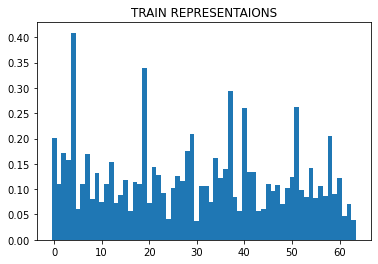

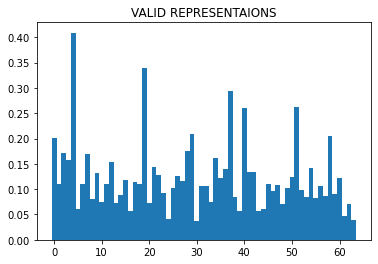

[205/366] shape      AUG[stl_2_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-58-56
   LINPROB: 0.915
[206/366] scale      AUG[stl_2_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-58-56
   LINPROB: 0.495
[207/366] color      AUG[stl_2_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-58-56
   LINPROB: 0.081
[208/366] angle      AUG[stl_2_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-58-56
   LINPROB: 0.186
[209/366] py         AUG[stl_2_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-58-56
   LINPROB: 0.071
[210/366] px         AUG[stl_2_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-58-56
   LINPROB: 0.064


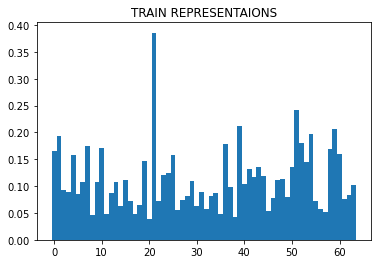

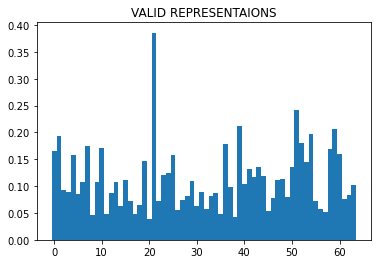

[211/366] shape      AUG[stl_2_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_09-39-44
   LINPROB: 0.916
[212/366] scale      AUG[stl_2_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_09-39-44
   LINPROB: 0.572
[213/366] color      AUG[stl_2_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_09-39-44
   LINPROB: 0.086
[214/366] angle      AUG[stl_2_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_09-39-44
   LINPROB: 0.136
[215/366] py         AUG[stl_2_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_09-39-44
   LINPROB: 0.072
[216/366] px         AUG[stl_2_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_09-39-44
   LINPROB: 0.069


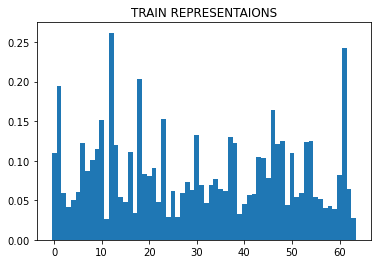

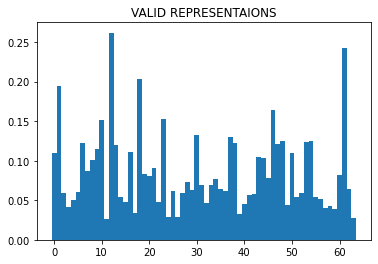

[217/366] shape      AUG[stl_3_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_10-20-56
   LINPROB: 0.487
[218/366] scale      AUG[stl_3_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_10-20-56
   LINPROB: 0.479
[219/366] color      AUG[stl_3_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_10-20-56
   LINPROB: 0.047
[220/366] angle      AUG[stl_3_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_10-20-56
   LINPROB: 0.070
[221/366] py         AUG[stl_3_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_10-20-56
   LINPROB: 0.354
[222/366] px         AUG[stl_3_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_10-20-56
   LINPROB: 0.333


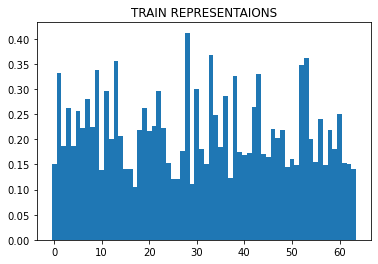

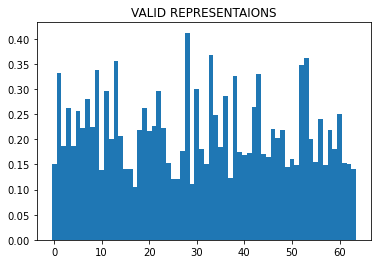

[223/366] shape      AUG[stl_3_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-01-13
   LINPROB: 0.916
[224/366] scale      AUG[stl_3_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-01-13
   LINPROB: 0.559
[225/366] color      AUG[stl_3_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-01-13
   LINPROB: 0.084
[226/366] angle      AUG[stl_3_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-01-13
   LINPROB: 0.168
[227/366] py         AUG[stl_3_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-01-13
   LINPROB: 0.102
[228/366] px         AUG[stl_3_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-01-13
   LINPROB: 0.113


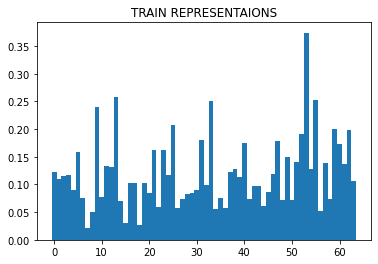

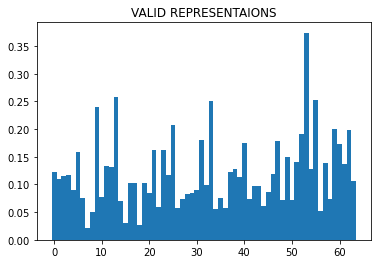

[229/366] shape      AUG[stl_3_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-42-15
   LINPROB: 0.908
[230/366] scale      AUG[stl_3_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-42-15
   LINPROB: 0.534
[231/366] color      AUG[stl_3_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-42-15
   LINPROB: 0.083
[232/366] angle      AUG[stl_3_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-42-15
   LINPROB: 0.190
[233/366] py         AUG[stl_3_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-42-15
   LINPROB: 0.079
[234/366] px         AUG[stl_3_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-42-15
   LINPROB: 0.093


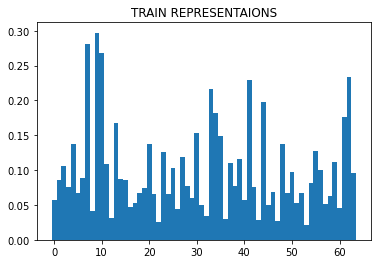

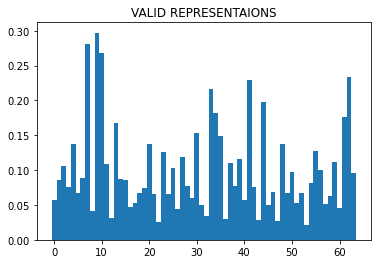

[235/366] shape      AUG[stl_3_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_12-23-33
   LINPROB: 0.924
[236/366] scale      AUG[stl_3_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_12-23-33
   LINPROB: 0.530
[237/366] color      AUG[stl_3_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_12-23-33
   LINPROB: 0.083
[238/366] angle      AUG[stl_3_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_12-23-33
   LINPROB: 0.194
[239/366] py         AUG[stl_3_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_12-23-33
   LINPROB: 0.075
[240/366] px         AUG[stl_3_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_12-23-33
   LINPROB: 0.071


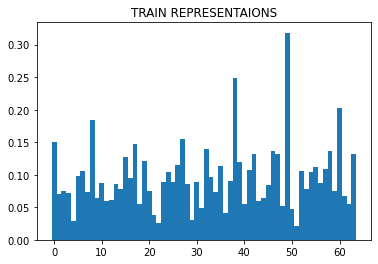

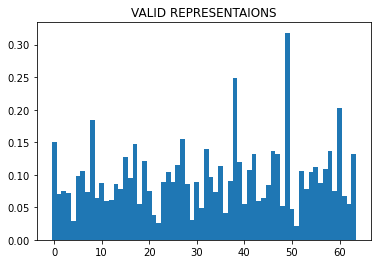

[241/366] shape      AUG[stl_3_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-04-30
   LINPROB: 0.931
[242/366] scale      AUG[stl_3_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-04-30
   LINPROB: 0.506
[243/366] color      AUG[stl_3_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-04-30
   LINPROB: 0.080
[244/366] angle      AUG[stl_3_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-04-30
   LINPROB: 0.212
[245/366] py         AUG[stl_3_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-04-30
   LINPROB: 0.066
[246/366] px         AUG[stl_3_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-04-30
   LINPROB: 0.070


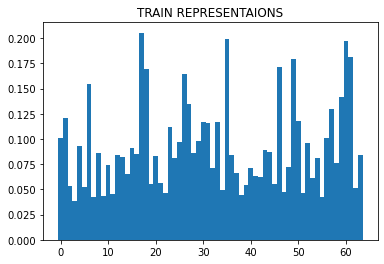

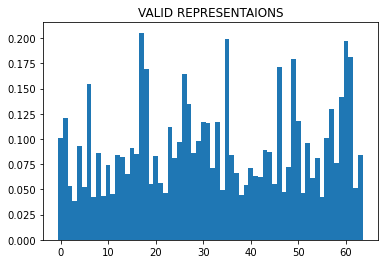

[247/366] shape      AUG[stl_4_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-45-46
   LINPROB: 0.463
[248/366] scale      AUG[stl_4_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-45-46
   LINPROB: 0.452
[249/366] color      AUG[stl_4_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-45-46
   LINPROB: 0.058
[250/366] angle      AUG[stl_4_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-45-46
   LINPROB: 0.073
[251/366] py         AUG[stl_4_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-45-46
   LINPROB: 0.340
[252/366] px         AUG[stl_4_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-45-46
   LINPROB: 0.342


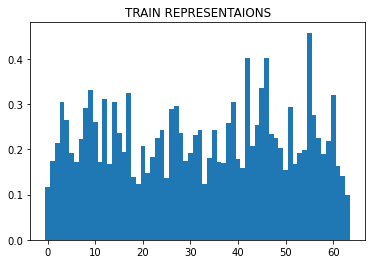

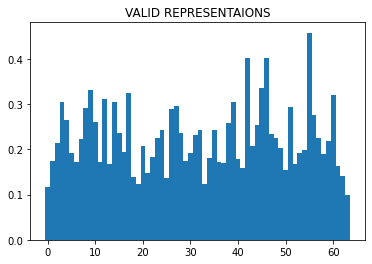

[253/366] shape      AUG[stl_4_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_14-26-14
   LINPROB: 0.929
[254/366] scale      AUG[stl_4_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_14-26-14
   LINPROB: 0.562
[255/366] color      AUG[stl_4_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_14-26-14
   LINPROB: 0.079
[256/366] angle      AUG[stl_4_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_14-26-14
   LINPROB: 0.218
[257/366] py         AUG[stl_4_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_14-26-14
   LINPROB: 0.117
[258/366] px         AUG[stl_4_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_14-26-14
   LINPROB: 0.098


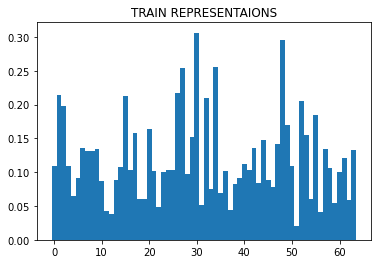

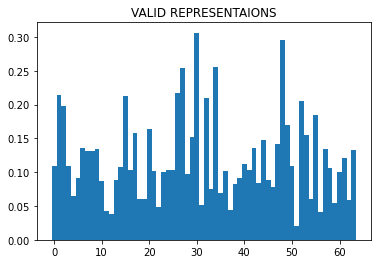

[259/366] shape      AUG[stl_4_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-07-38
   LINPROB: 0.926
[260/366] scale      AUG[stl_4_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-07-38
   LINPROB: 0.518
[261/366] color      AUG[stl_4_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-07-38
   LINPROB: 0.082
[262/366] angle      AUG[stl_4_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-07-38
   LINPROB: 0.202
[263/366] py         AUG[stl_4_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-07-38
   LINPROB: 0.078
[264/366] px         AUG[stl_4_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-07-38
   LINPROB: 0.095


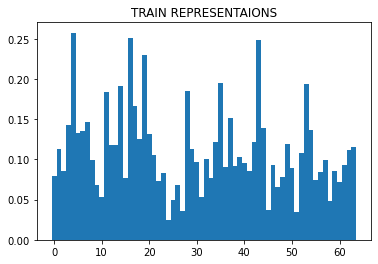

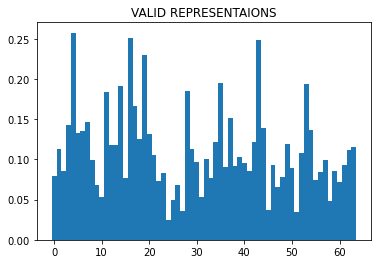

[265/366] shape      AUG[stl_4_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-48-38
   LINPROB: 0.897
[266/366] scale      AUG[stl_4_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-48-38
   LINPROB: 0.515
[267/366] color      AUG[stl_4_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-48-38
   LINPROB: 0.080
[268/366] angle      AUG[stl_4_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-48-38
   LINPROB: 0.206
[269/366] py         AUG[stl_4_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-48-38
   LINPROB: 0.063
[270/366] px         AUG[stl_4_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-48-38
   LINPROB: 0.071


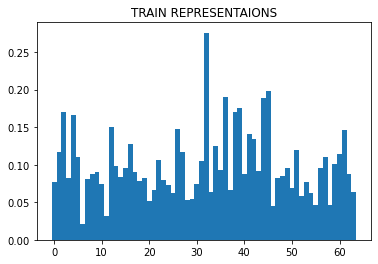

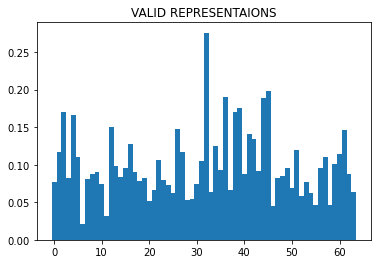

[271/366] shape      AUG[stl_4_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_16-29-54
   LINPROB: 0.971
[272/366] scale      AUG[stl_4_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_16-29-54
   LINPROB: 0.502
[273/366] color      AUG[stl_4_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_16-29-54
   LINPROB: 0.078
[274/366] angle      AUG[stl_4_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_16-29-54
   LINPROB: 0.269
[275/366] py         AUG[stl_4_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_16-29-54
   LINPROB: 0.065
[276/366] px         AUG[stl_4_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_16-29-54
   LINPROB: 0.064


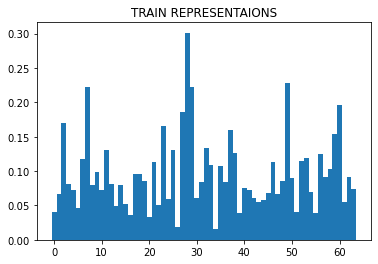

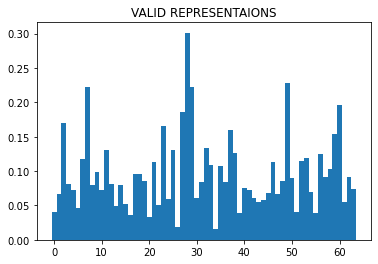

[277/366] shape      AUG[stl_5_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-10-53
   LINPROB: 0.498
[278/366] scale      AUG[stl_5_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-10-53
   LINPROB: 0.466
[279/366] color      AUG[stl_5_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-10-53
   LINPROB: 0.046
[280/366] angle      AUG[stl_5_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-10-53
   LINPROB: 0.078
[281/366] py         AUG[stl_5_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-10-53
   LINPROB: 0.350
[282/366] px         AUG[stl_5_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-10-53
   LINPROB: 0.339


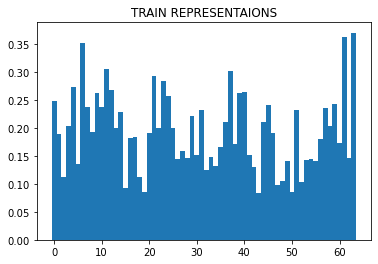

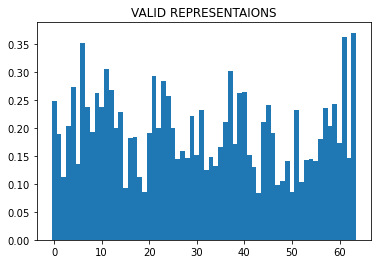

[283/366] shape      AUG[stl_5_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-51-38
   LINPROB: 0.931
[284/366] scale      AUG[stl_5_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-51-38
   LINPROB: 0.600
[285/366] color      AUG[stl_5_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-51-38
   LINPROB: 0.081
[286/366] angle      AUG[stl_5_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-51-38
   LINPROB: 0.193
[287/366] py         AUG[stl_5_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-51-38
   LINPROB: 0.136
[288/366] px         AUG[stl_5_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-51-38
   LINPROB: 0.147


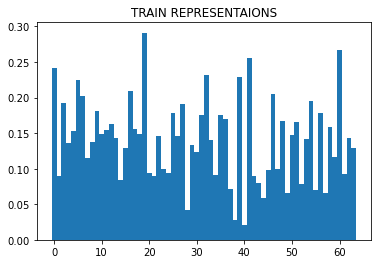

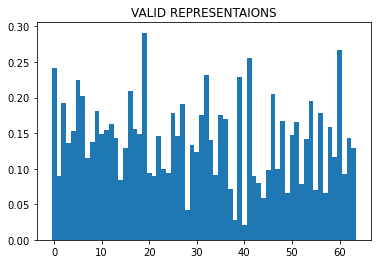

[289/366] shape      AUG[stl_5_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_18-32-48
   LINPROB: 0.927
[290/366] scale      AUG[stl_5_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_18-32-48
   LINPROB: 0.594
[291/366] color      AUG[stl_5_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_18-32-48
   LINPROB: 0.083
[292/366] angle      AUG[stl_5_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_18-32-48
   LINPROB: 0.200
[293/366] py         AUG[stl_5_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_18-32-48
   LINPROB: 0.092
[294/366] px         AUG[stl_5_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_18-32-48
   LINPROB: 0.106


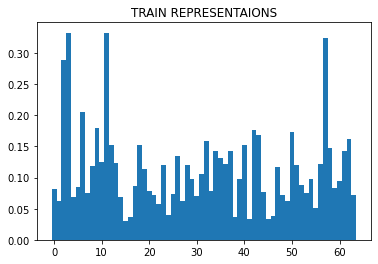

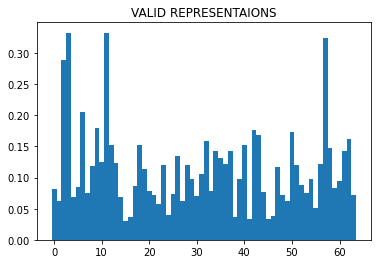

[295/366] shape      AUG[stl_5_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-14-17
   LINPROB: 0.939
[296/366] scale      AUG[stl_5_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-14-17
   LINPROB: 0.556
[297/366] color      AUG[stl_5_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-14-17
   LINPROB: 0.081
[298/366] angle      AUG[stl_5_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-14-17
   LINPROB: 0.237
[299/366] py         AUG[stl_5_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-14-17
   LINPROB: 0.070
[300/366] px         AUG[stl_5_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-14-17
   LINPROB: 0.071


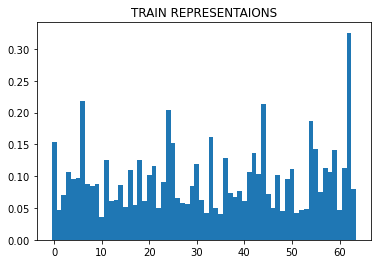

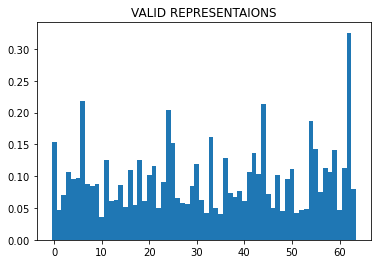

[301/366] shape      AUG[stl_5_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-55-23
   LINPROB: 0.944
[302/366] scale      AUG[stl_5_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-55-23
   LINPROB: 0.515
[303/366] color      AUG[stl_5_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-55-23
   LINPROB: 0.078
[304/366] angle      AUG[stl_5_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-55-23
   LINPROB: 0.257
[305/366] py         AUG[stl_5_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-55-23
   LINPROB: 0.071
[306/366] px         AUG[stl_5_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-55-23
   LINPROB: 0.065


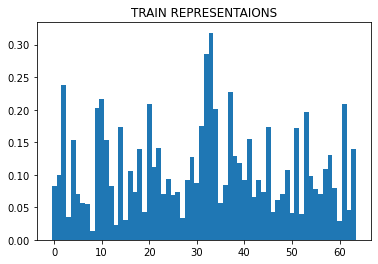

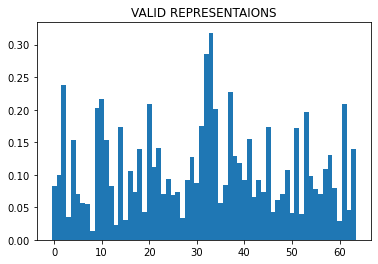

[307/366] shape      AUG[stl_6_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_20-36-28
   LINPROB: 0.476
[308/366] scale      AUG[stl_6_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_20-36-28
   LINPROB: 0.468
[309/366] color      AUG[stl_6_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_20-36-28
   LINPROB: 0.048
[310/366] angle      AUG[stl_6_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_20-36-28
   LINPROB: 0.071
[311/366] py         AUG[stl_6_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_20-36-28
   LINPROB: 0.349
[312/366] px         AUG[stl_6_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_20-36-28
   LINPROB: 0.382


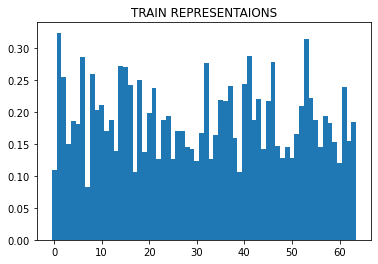

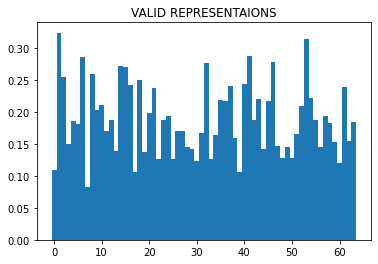

[313/366] shape      AUG[stl_6_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-17-08
   LINPROB: 0.936
[314/366] scale      AUG[stl_6_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-17-08
   LINPROB: 0.620
[315/366] color      AUG[stl_6_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-17-08
   LINPROB: 0.080
[316/366] angle      AUG[stl_6_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-17-08
   LINPROB: 0.235
[317/366] py         AUG[stl_6_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-17-08
   LINPROB: 0.157
[318/366] px         AUG[stl_6_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-17-08
   LINPROB: 0.139


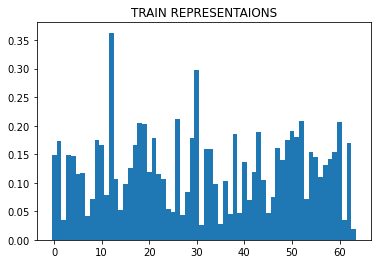

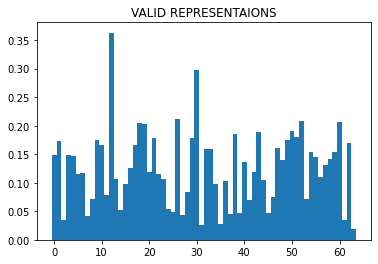

[319/366] shape      AUG[stl_6_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-58-13
   LINPROB: 0.945
[320/366] scale      AUG[stl_6_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-58-13
   LINPROB: 0.661
[321/366] color      AUG[stl_6_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-58-13
   LINPROB: 0.083
[322/366] angle      AUG[stl_6_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-58-13
   LINPROB: 0.214
[323/366] py         AUG[stl_6_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-58-13
   LINPROB: 0.122
[324/366] px         AUG[stl_6_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-58-13
   LINPROB: 0.140


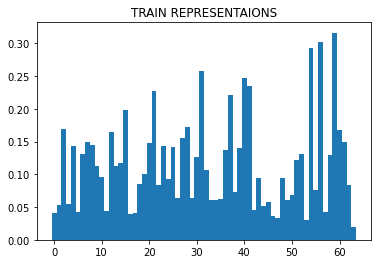

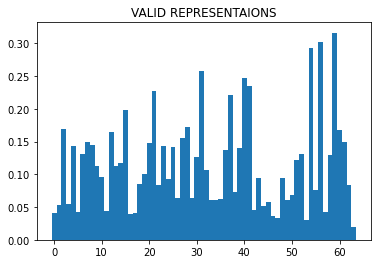

[325/366] shape      AUG[stl_6_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_22-39-31
   LINPROB: 0.944
[326/366] scale      AUG[stl_6_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_22-39-31
   LINPROB: 0.569
[327/366] color      AUG[stl_6_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_22-39-31
   LINPROB: 0.080
[328/366] angle      AUG[stl_6_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_22-39-31
   LINPROB: 0.238
[329/366] py         AUG[stl_6_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_22-39-31
   LINPROB: 0.075
[330/366] px         AUG[stl_6_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_22-39-31
   LINPROB: 0.080


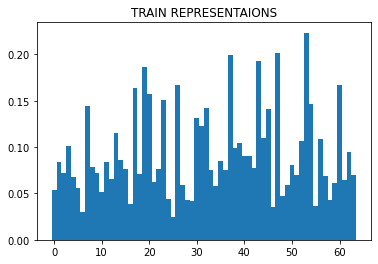

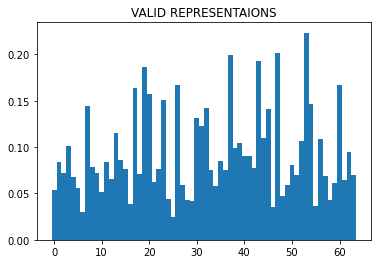

[331/366] shape      AUG[stl_6_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_23-20-33
   LINPROB: 0.976
[332/366] scale      AUG[stl_6_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_23-20-33
   LINPROB: 0.512
[333/366] color      AUG[stl_6_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_23-20-33
   LINPROB: 0.080
[334/366] angle      AUG[stl_6_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_23-20-33
   LINPROB: 0.264
[335/366] py         AUG[stl_6_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_23-20-33
   LINPROB: 0.066
[336/366] px         AUG[stl_6_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_23-20-33
   LINPROB: 0.067


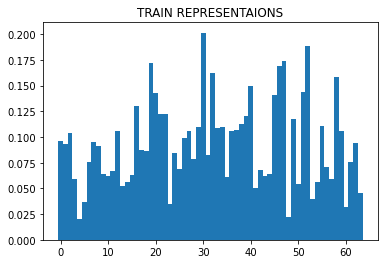

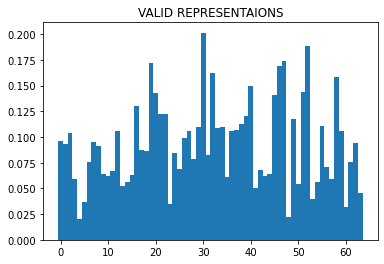

[337/366] shape      AUG[stl_7_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-01-52
   LINPROB: 0.508
[338/366] scale      AUG[stl_7_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-01-52
   LINPROB: 0.485
[339/366] color      AUG[stl_7_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-01-52
   LINPROB: 0.047
[340/366] angle      AUG[stl_7_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-01-52
   LINPROB: 0.076
[341/366] py         AUG[stl_7_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-01-52
   LINPROB: 0.351
[342/366] px         AUG[stl_7_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-01-52
   LINPROB: 0.343


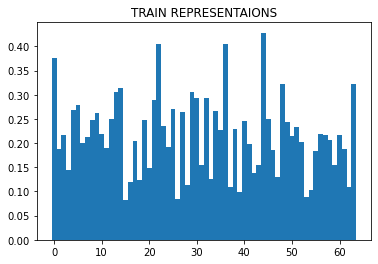

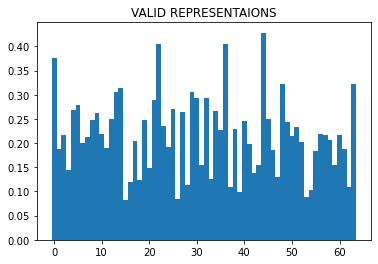

[343/366] shape      AUG[stl_7_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-42-24
   LINPROB: 0.943
[344/366] scale      AUG[stl_7_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-42-24
   LINPROB: 0.594
[345/366] color      AUG[stl_7_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-42-24
   LINPROB: 0.073
[346/366] angle      AUG[stl_7_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-42-24
   LINPROB: 0.193
[347/366] py         AUG[stl_7_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-42-24
   LINPROB: 0.161
[348/366] px         AUG[stl_7_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-42-24
   LINPROB: 0.162


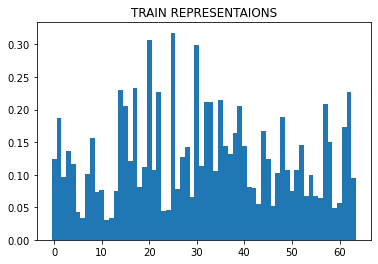

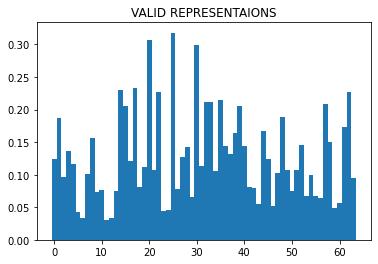

[349/366] shape      AUG[stl_7_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-12_01-23-55
   LINPROB: 0.959
[350/366] scale      AUG[stl_7_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-12_01-23-55
   LINPROB: 0.671
[351/366] color      AUG[stl_7_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-12_01-23-55
   LINPROB: 0.080
[352/366] angle      AUG[stl_7_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-12_01-23-55
   LINPROB: 0.214
[353/366] py         AUG[stl_7_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-12_01-23-55
   LINPROB: 0.118
[354/366] px         AUG[stl_7_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-12_01-23-55
   LINPROB: 0.132


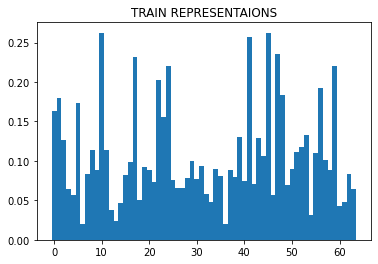

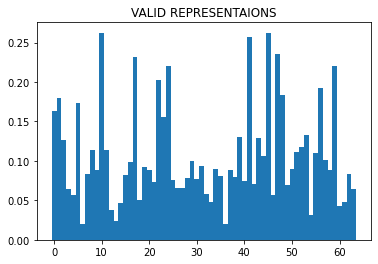

[355/366] shape      AUG[stl_7_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-05-21
   LINPROB: 0.982
[356/366] scale      AUG[stl_7_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-05-21
   LINPROB: 0.615
[357/366] color      AUG[stl_7_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-05-21
   LINPROB: 0.082
[358/366] angle      AUG[stl_7_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-05-21
   LINPROB: 0.295
[359/366] py         AUG[stl_7_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-05-21
   LINPROB: 0.075
[360/366] px         AUG[stl_7_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-05-21
   LINPROB: 0.085


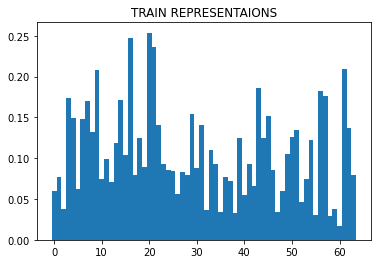

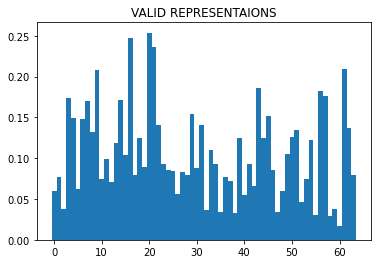

[361/366] shape      AUG[stl_7_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-46-29
   LINPROB: 0.980
[362/366] scale      AUG[stl_7_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-46-29
   LINPROB: 0.582
[363/366] color      AUG[stl_7_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-46-29
   LINPROB: 0.084
[364/366] angle      AUG[stl_7_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-46-29
   LINPROB: 0.259
[365/366] py         AUG[stl_7_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-46-29
   LINPROB: 0.090
[366/366] px         AUG[stl_7_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-46-29
   LINPROB: 0.079


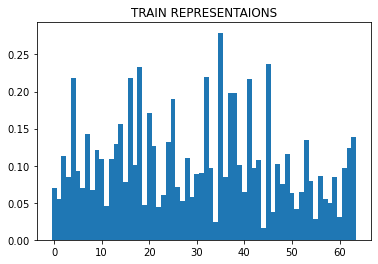

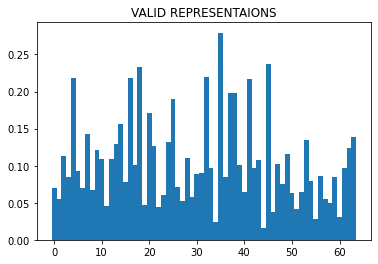

In [8]:
step = 1
max_steps = len(p_experiments) * 6
print_str = "[{:>3}/{:>3}] {:<10} {}"
for p_experiment in p_experiments:
    experiment_name = p_experiment.name
    
    # experiment config
    p_experiment_config = p_experiment / "config.pkl"
    with open(p_experiment_config, "rb") as file:
        experiment_config = pickle.load(file)
    # dataset config
    p_ds_config = Path(experiment_config.p_data) / "config.pkl"
    with open(p_ds_config, "rb") as file:
        ds_config = pickle.load(file)

    results = {}
    for target_variable in ds_config["classes"]:
        print(print_str.format(step, max_steps, target_variable, experiment_name))
        target_idx = [idx for idx, target in enumerate(ds_config["classes"]) if target == target_variable][0]
        n_classes = ds_config["n_classes"][target_variable]
        #
        R_train, Y_train, R_valid, Y_valid = load_data_tensors(
                target_idx,
                p_experiment / experiment_config["p_R_train"],
                p_experiment / experiment_config["p_Y_train"],
                p_experiment / experiment_config["p_R_valid"],
                p_experiment / experiment_config["p_Y_valid"])
        #
        clf = LogisticRegression(random_state=0).fit(R_train, Y_train)
        score = clf.score(R_valid, Y_valid)
        print("   LINPROB: {:.3f}".format(score))
p_experiments_base = Path("/mnt/experiments/csprites/single_csprites_64x64_n7_c32_a32_p30_s3_bg_inf_random_function_70000")
p_experiments = [
    # SUP
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[shape]',
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[scale]',
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[color]',
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[angle]',
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[py]',
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[px]',
    
    # ARCHITECTURE SEARCH
    p_experiments_base / 'BTwins_[FCN8i223o32_d_16]_2021-09-11_04-48-41',
    p_experiments_base / 'BTwins_[FCN8i223o32_d_32]_2021-09-11_03-59-30',
    p_experiments_base / 'BTwins_[FCN8i223o32_d_64]_2021-09-11_03-11-37',
    p_experiments_base / 'BTwins_[FCN8i223o32_d_128]_2021-09-11_02-22-23',
    p_experiments_base / 'BTwins_[FCN8i223o32_d_256]_2021-09-11_01-32-15',
    p_experiments_base / 'BTwins_[FCN16i223o64_d_16]_2021-09-11_00-41-44',
    p_experiments_base / 'BTwins_[FCN16i223o64_d_32]_2021-09-10_23-51-29',
    p_experiments_base / 'BTwins_[FCN16i223o64_d_64]_2021-09-10_23-01-29',
    p_experiments_base / 'BTwins_[FCN16i223o64_d_128]_2021-09-10_22-17-49',
    p_experiments_base / 'BTwins_[FCN16i223o64_d_256]_2021-09-10_21-34-28',
    p_experiments_base / 'BTwins_[FCN32i223o128_d_16]_2021-09-10_20-32-27',
    p_experiments_base / 'BTwins_[FCN32i223o128_d_32]_2021-09-10_19-29-52',
    p_experiments_base / 'BTwins_[FCN32i223o128_d_64]_2021-09-10_18-27-52',
    p_experiments_base / 'BTwins_[FCN32i223o128_d_128]_2021-09-10_17-25-13',
    p_experiments_base / 'BTwins_[FCN32i223o128_d_256]_2021-09-10_16-21-00',
    
    # AUGMENTATION
    p_experiments_base / 'AUG[stl_0_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-10_22-59-21',
    p_experiments_base / 'AUG[stl_0_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-10_23-46-54',
    p_experiments_base / 'AUG[stl_0_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_00-36-46',
    p_experiments_base / 'AUG[stl_0_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_01-26-18',
    p_experiments_base / 'AUG[stl_0_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_02-15-29',
    p_experiments_base / 'AUG[stl_1_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-04-49',
    p_experiments_base / 'AUG[stl_1_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-52-48',
    p_experiments_base / 'AUG[stl_1_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_04-43-28',
    p_experiments_base / 'AUG[stl_1_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_05-33-59',
    p_experiments_base / 'AUG[stl_1_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-15-44',
    p_experiments_base / 'AUG[stl_2_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-56-34',
    p_experiments_base / 'AUG[stl_2_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_07-37-11',
    p_experiments_base / 'AUG[stl_2_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-18-06',
    p_experiments_base / 'AUG[stl_2_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-58-56',
    p_experiments_base / 'AUG[stl_2_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_09-39-44',
    p_experiments_base / 'AUG[stl_3_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_10-20-56',
    p_experiments_base / 'AUG[stl_3_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-01-13',
    p_experiments_base / 'AUG[stl_3_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-42-15',
    p_experiments_base / 'AUG[stl_3_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_12-23-33',
    p_experiments_base / 'AUG[stl_3_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-04-30',
    p_experiments_base / 'AUG[stl_4_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-45-46',
    p_experiments_base / 'AUG[stl_4_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_14-26-14',
    p_experiments_base / 'AUG[stl_4_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-07-38',
    p_experiments_base / 'AUG[stl_4_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-48-38',
    p_experiments_base / 'AUG[stl_4_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_16-29-54',
    p_experiments_base / 'AUG[stl_5_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-10-53',
    p_experiments_base / 'AUG[stl_5_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-51-38',
    p_experiments_base / 'AUG[stl_5_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_18-32-48',
    p_experiments_base / 'AUG[stl_5_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-14-17',
    p_experiments_base / 'AUG[stl_5_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-55-23',
    p_experiments_base / 'AUG[stl_6_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_20-36-28',
    p_experiments_base / 'AUG[stl_6_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-17-08',
    p_experiments_base / 'AUG[stl_6_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-58-13',
    p_experiments_base / 'AUG[stl_6_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_22-39-31',
    p_experiments_base / 'AUG[stl_6_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_23-20-33',
    p_experiments_base / 'AUG[stl_7_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-01-52',
    p_experiments_base / 'AUG[stl_7_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-42-24',
    p_experiments_base / 'AUG[stl_7_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-12_01-23-55',
    p_experiments_base / 'AUG[stl_7_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-05-21',
    p_experiments_base / 'AUG[stl_7_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-46-29',
]
for p in p_experiments:
    if not p.exists():
        print(p)
        results[target_variable] = score
        step += 1
    p_results = p_experiment / linprob_config["p_results"]
    p_linprob_config = p_experiment / linprob_config["p_config"]
    #
    plt.bar(range(R_train.shape[1]),R_train.mean(axis=0), width=1)
    plt.title("TRAIN REPRESENTAIONS")
    plt.savefig(p_experiment / "R_train_feature_mean.png")
    plt.show()
    plt.bar(range(R_valid.shape[1]),R_train.mean(axis=0), width=1)
    plt.title("VALID REPRESENTAIONS")
    plt.savefig(p_experiment / "R_valid_feature_mean.png")
    plt.show()
    #
    with open(p_results, "wb") as file:
        pickle.dump(results, file)
    with open(p_linprob_config, "wb") as file:
        pickle.dump(linprob_config, file)

# Load all results 

In [34]:
p_experiments_base = Path("/mnt/experiments/csprites/single_csprites_64x64_n7_c32_a32_p30_s3_bg_inf_random_function_70000")
p_experiments = [
    # SUP
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[shape]',
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[scale]',
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[color]',
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[angle]',
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[py]',
    p_experiments_base / 'SUP_[FCN8i223o32_d128]_target_[px]',
    
    # ARCHITECTURE SEARCH
    p_experiments_base / 'BTwins_[FCN8i223o32_d_16]_2021-09-11_04-48-41',
    p_experiments_base / 'BTwins_[FCN8i223o32_d_32]_2021-09-11_03-59-30',
    p_experiments_base / 'BTwins_[FCN8i223o32_d_64]_2021-09-11_03-11-37',
    p_experiments_base / 'BTwins_[FCN8i223o32_d_128]_2021-09-11_02-22-23',
    p_experiments_base / 'BTwins_[FCN8i223o32_d_256]_2021-09-11_01-32-15',
    p_experiments_base / 'BTwins_[FCN16i223o64_d_16]_2021-09-11_00-41-44',
    p_experiments_base / 'BTwins_[FCN16i223o64_d_32]_2021-09-10_23-51-29',
    p_experiments_base / 'BTwins_[FCN16i223o64_d_64]_2021-09-10_23-01-29',
    p_experiments_base / 'BTwins_[FCN16i223o64_d_128]_2021-09-10_22-17-49',
    p_experiments_base / 'BTwins_[FCN16i223o64_d_256]_2021-09-10_21-34-28',
    p_experiments_base / 'BTwins_[FCN32i223o128_d_16]_2021-09-10_20-32-27',
    p_experiments_base / 'BTwins_[FCN32i223o128_d_32]_2021-09-10_19-29-52',
    p_experiments_base / 'BTwins_[FCN32i223o128_d_64]_2021-09-10_18-27-52',
    p_experiments_base / 'BTwins_[FCN32i223o128_d_128]_2021-09-10_17-25-13',
    p_experiments_base / 'BTwins_[FCN32i223o128_d_256]_2021-09-10_16-21-00',
    
    # AUGMENTATION STYLE INCREASE
    p_experiments_base / 'AUG[stl_0_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-10_22-59-21',
    p_experiments_base / 'AUG[stl_1_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-04-49',
    p_experiments_base / 'AUG[stl_2_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-56-34',
    p_experiments_base / 'AUG[stl_3_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_10-20-56',
    p_experiments_base / 'AUG[stl_4_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-45-46',
    p_experiments_base / 'AUG[stl_5_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-10-53',
    p_experiments_base / 'AUG[stl_6_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_20-36-28',
    p_experiments_base / 'AUG[stl_7_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-01-52',

    p_experiments_base / 'AUG[stl_0_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-10_23-46-54',
    p_experiments_base / 'AUG[stl_1_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-52-48',
    p_experiments_base / 'AUG[stl_2_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_07-37-11',
    p_experiments_base / 'AUG[stl_3_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-01-13',
    p_experiments_base / 'AUG[stl_4_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_14-26-14',
    p_experiments_base / 'AUG[stl_5_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-51-38',
    p_experiments_base / 'AUG[stl_6_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-17-08',
    p_experiments_base / 'AUG[stl_7_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-42-24',

    p_experiments_base / 'AUG[stl_0_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_00-36-46',
    p_experiments_base / 'AUG[stl_1_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_04-43-28',
    p_experiments_base / 'AUG[stl_2_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-18-06',
    p_experiments_base / 'AUG[stl_3_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-42-15',
    p_experiments_base / 'AUG[stl_4_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-07-38',
    p_experiments_base / 'AUG[stl_5_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_18-32-48',
    p_experiments_base / 'AUG[stl_6_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-58-13',
    p_experiments_base / 'AUG[stl_7_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-12_01-23-55',

    p_experiments_base / 'AUG[stl_0_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_01-26-18',
    p_experiments_base / 'AUG[stl_1_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_05-33-59',
    p_experiments_base / 'AUG[stl_2_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-58-56',
    p_experiments_base / 'AUG[stl_3_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_12-23-33',
    p_experiments_base / 'AUG[stl_4_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-48-38',
    p_experiments_base / 'AUG[stl_5_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-14-17',
    p_experiments_base / 'AUG[stl_6_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_22-39-31',
    p_experiments_base / 'AUG[stl_7_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-05-21',

    p_experiments_base / 'AUG[stl_0_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_02-15-29',
    p_experiments_base / 'AUG[stl_1_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-15-44',
    p_experiments_base / 'AUG[stl_2_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_09-39-44',
    p_experiments_base / 'AUG[stl_3_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-04-30',
    p_experiments_base / 'AUG[stl_4_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_16-29-54',
    p_experiments_base / 'AUG[stl_5_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-55-23',
    p_experiments_base / 'AUG[stl_6_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_23-20-33',
    p_experiments_base / 'AUG[stl_7_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-46-29',
]
for p in p_experiments:
    if not p.exists():
        print(p)

In [35]:
p_eval =  p_experiments_base / linprob_config["p_eval"]
p_eval.mkdir(exist_ok=True)
p_results = p_eval / linprob_config["p_results"]
p_config = p_eval / linprob_config["p_config"]
p_acc_map = p_eval / linprob_config["p_acc_mat"]

In [36]:
experiment_results = {}
for p_experiment in p_experiments:
    experiment_name = p_experiment.name
    print(experiment_name)
    #
    p_results = p_experiment / linprob_config["p_results"]
    #
    with open(p_results, "rb") as file:
        results = pickle.load(file)
    experiment_results[experiment_name] = results

SUP_[FCN8i223o32_d128]_target_[shape]
SUP_[FCN8i223o32_d128]_target_[scale]
SUP_[FCN8i223o32_d128]_target_[color]
SUP_[FCN8i223o32_d128]_target_[angle]
SUP_[FCN8i223o32_d128]_target_[py]
SUP_[FCN8i223o32_d128]_target_[px]
BTwins_[FCN8i223o32_d_16]_2021-09-11_04-48-41
BTwins_[FCN8i223o32_d_32]_2021-09-11_03-59-30
BTwins_[FCN8i223o32_d_64]_2021-09-11_03-11-37
BTwins_[FCN8i223o32_d_128]_2021-09-11_02-22-23
BTwins_[FCN8i223o32_d_256]_2021-09-11_01-32-15
BTwins_[FCN16i223o64_d_16]_2021-09-11_00-41-44
BTwins_[FCN16i223o64_d_32]_2021-09-10_23-51-29
BTwins_[FCN16i223o64_d_64]_2021-09-10_23-01-29
BTwins_[FCN16i223o64_d_128]_2021-09-10_22-17-49
BTwins_[FCN16i223o64_d_256]_2021-09-10_21-34-28
BTwins_[FCN32i223o128_d_16]_2021-09-10_20-32-27
BTwins_[FCN32i223o128_d_32]_2021-09-10_19-29-52
BTwins_[FCN32i223o128_d_64]_2021-09-10_18-27-52
BTwins_[FCN32i223o128_d_128]_2021-09-10_17-25-13
BTwins_[FCN32i223o128_d_256]_2021-09-10_16-21-00
AUG[stl_0_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-10_22-59-21
AUG

In [37]:
acc_results = []
for experiment_name in experiment_results.keys():
    results = experiment_results[experiment_name]
        # targets
    targets = list(results.keys())
    accs = [results[t] for t in targets]
    acc_results.append(accs)
acc_matrix = np.array(acc_results)
path_experiment_names = [n for n in experiment_results.keys()]
#
experiment_names = []
for name in path_experiment_names:
    if "_2021-09" in name:
        experiment_names.append(name[:-21])
    else:
        experiment_names.append(name)

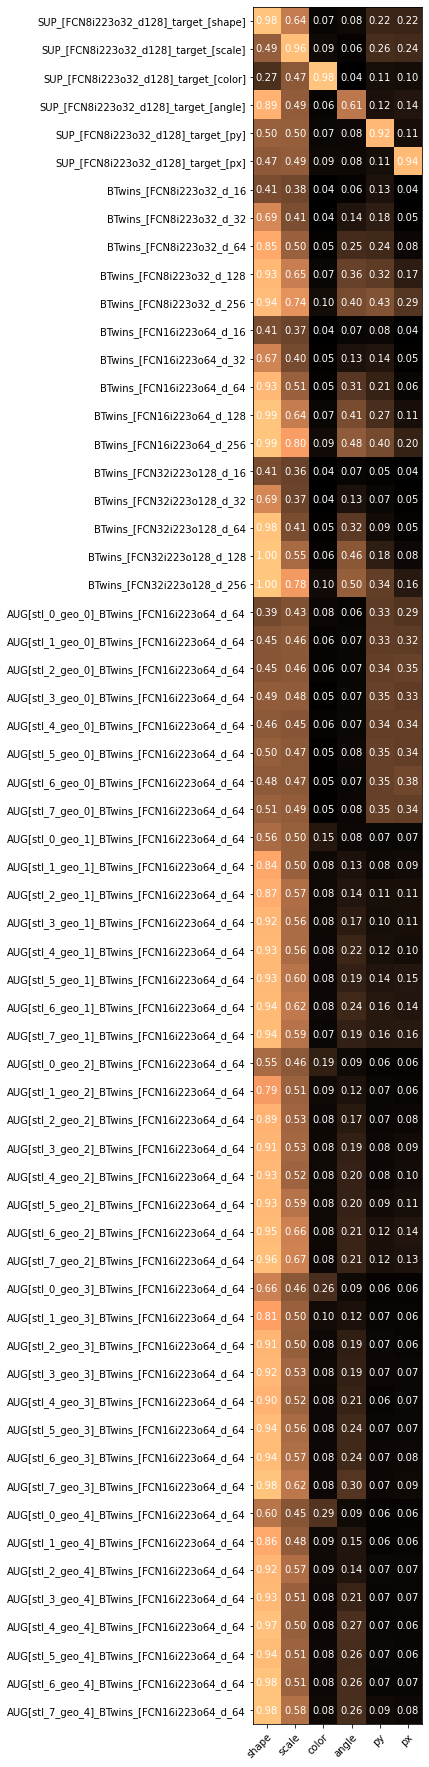

In [38]:
plot_mat(acc_matrix, experiment_names, targets, scale_factor=1, p_file=p_acc_map)

In [20]:
for p in p_experiments:
    R_train = np.load(p / "R_train.npy")
    print("{:<40}: {:.3f} {:.3f} {:.3f}".format(p.name, R_train.min(), R_train.mean(),R_train.max()))

SUP_[FCN8i223o32_d128]_target_[shape]   : 0.000 0.570 4.255
SUP_[FCN8i223o32_d128]_target_[scale]   : 0.000 0.471 3.649
SUP_[FCN8i223o32_d128]_target_[color]   : 0.000 0.656 10.063
SUP_[FCN8i223o32_d128]_target_[angle]   : 0.000 0.882 9.800
SUP_[FCN8i223o32_d128]_target_[py]      : 0.000 0.839 6.487
SUP_[FCN8i223o32_d128]_target_[px]      : 0.000 0.883 6.798
BTwins_[FCN8i223o32_d_16]_2021-09-11_04-48-41: 0.000 0.377 3.322
BTwins_[FCN8i223o32_d_32]_2021-09-11_03-59-30: 0.000 0.232 2.547
BTwins_[FCN8i223o32_d_64]_2021-09-11_03-11-37: 0.000 0.165 2.306
BTwins_[FCN8i223o32_d_128]_2021-09-11_02-22-23: 0.000 0.154 2.416
BTwins_[FCN8i223o32_d_256]_2021-09-11_01-32-15: 0.000 0.125 2.086
BTwins_[FCN16i223o64_d_16]_2021-09-11_00-41-44: 0.000 0.358 2.769
BTwins_[FCN16i223o64_d_32]_2021-09-10_23-51-29: 0.000 0.217 2.373
BTwins_[FCN16i223o64_d_64]_2021-09-10_23-01-29: 0.000 0.161 1.731
BTwins_[FCN16i223o64_d_128]_2021-09-10_22-17-49: 0.000 0.110 2.601
BTwins_[FCN16i223o64_d_256]_2021-09-10_21-34-28

SUP_[FCN8i223o32_d128]_target_[shape]   : 0.000 0.570 4.255


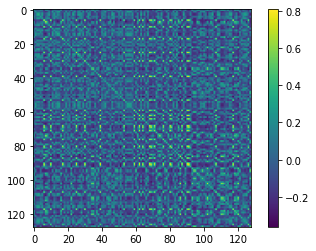

SUP_[FCN8i223o32_d128]_target_[scale]   : 0.000 0.471 3.649


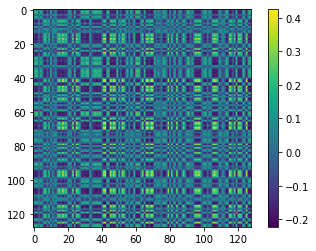

SUP_[FCN8i223o32_d128]_target_[color]   : 0.000 0.656 10.063


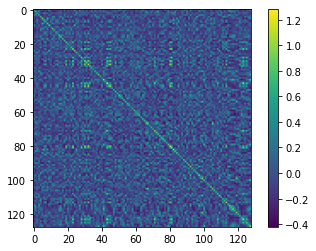

SUP_[FCN8i223o32_d128]_target_[angle]   : 0.000 0.882 9.800


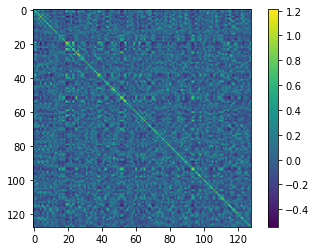

SUP_[FCN8i223o32_d128]_target_[py]      : 0.000 0.839 6.487


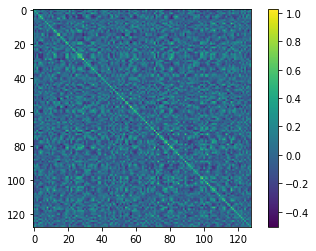

SUP_[FCN8i223o32_d128]_target_[px]      : 0.000 0.883 6.798


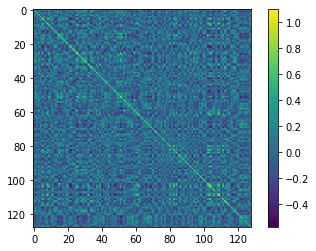

BTwins_[FCN8i223o32_d_16]_2021-09-11_04-48-41: 0.000 0.377 3.322


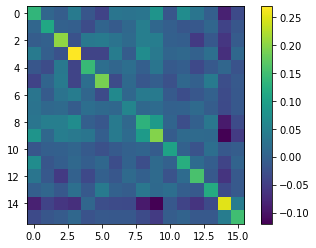

BTwins_[FCN8i223o32_d_32]_2021-09-11_03-59-30: 0.000 0.232 2.547


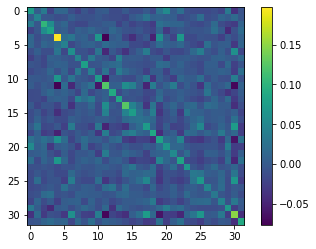

BTwins_[FCN8i223o32_d_64]_2021-09-11_03-11-37: 0.000 0.165 2.306


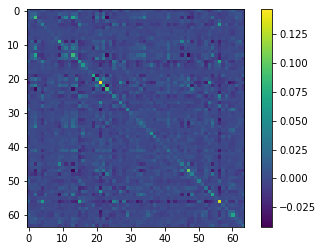

BTwins_[FCN8i223o32_d_128]_2021-09-11_02-22-23: 0.000 0.154 2.416


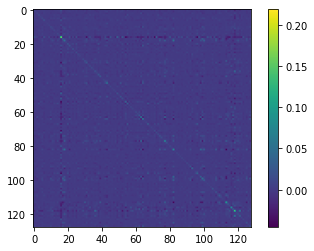

BTwins_[FCN8i223o32_d_256]_2021-09-11_01-32-15: 0.000 0.125 2.086


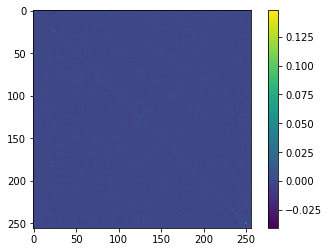

BTwins_[FCN16i223o64_d_16]_2021-09-11_00-41-44: 0.000 0.358 2.769


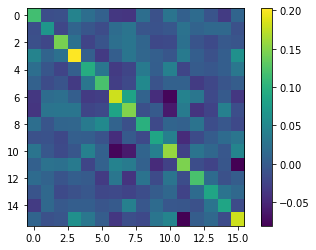

BTwins_[FCN16i223o64_d_32]_2021-09-10_23-51-29: 0.000 0.217 2.373


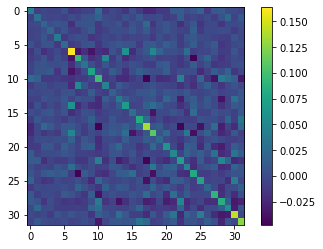

BTwins_[FCN16i223o64_d_64]_2021-09-10_23-01-29: 0.000 0.161 1.731


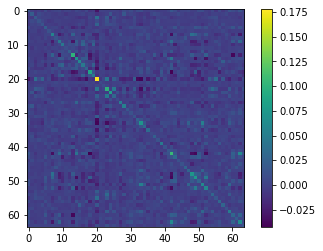

BTwins_[FCN16i223o64_d_128]_2021-09-10_22-17-49: 0.000 0.110 2.601


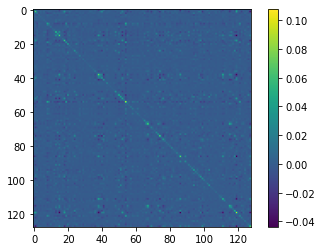

BTwins_[FCN16i223o64_d_256]_2021-09-10_21-34-28: 0.000 0.101 2.123


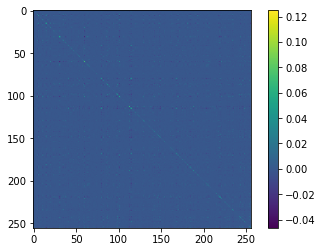

BTwins_[FCN32i223o128_d_16]_2021-09-10_20-32-27: 0.000 0.310 3.076


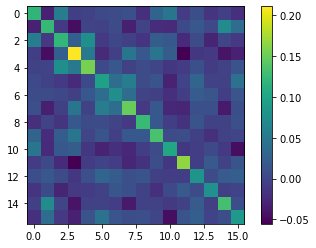

BTwins_[FCN32i223o128_d_32]_2021-09-10_19-29-52: 0.000 0.199 2.704


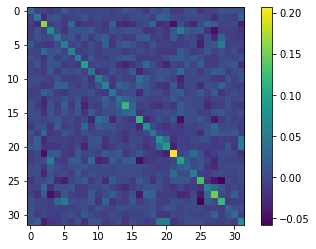

BTwins_[FCN32i223o128_d_64]_2021-09-10_18-27-52: 0.000 0.121 2.643


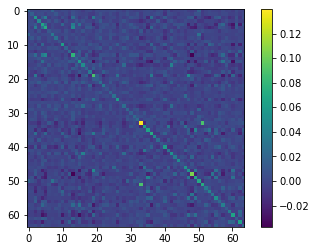

BTwins_[FCN32i223o128_d_128]_2021-09-10_17-25-13: 0.000 0.097 2.977


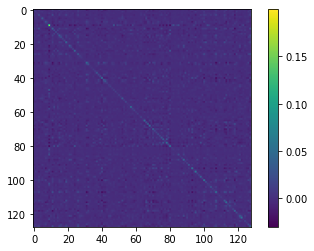

BTwins_[FCN32i223o128_d_256]_2021-09-10_16-21-00: 0.000 0.086 3.442


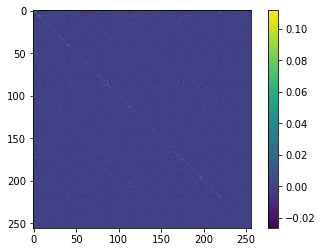

AUG[stl_0_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-10_22-59-21: 0.000 0.220 1.083


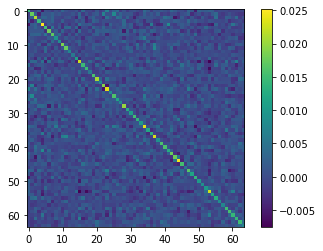

AUG[stl_0_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-10_23-46-54: 0.000 0.178 2.930


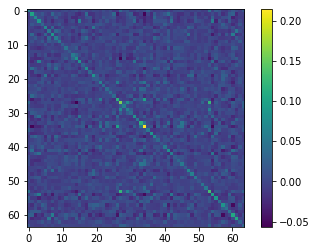

AUG[stl_0_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_00-36-46: 0.000 0.160 2.522


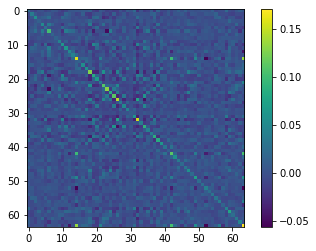

AUG[stl_0_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_01-26-18: 0.000 0.144 3.151


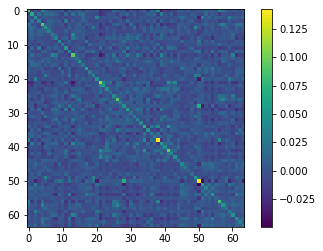

AUG[stl_0_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_02-15-29: 0.000 0.142 2.396


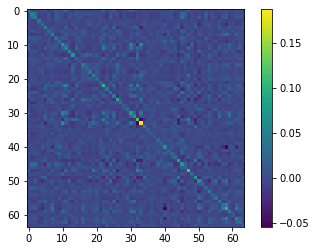

AUG[stl_1_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-04-49: 0.000 0.225 1.143


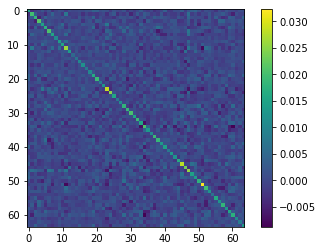

AUG[stl_1_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_03-52-48: 0.000 0.131 3.328


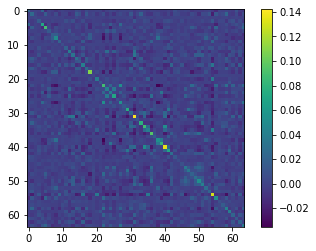

AUG[stl_1_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_04-43-28: 0.000 0.138 2.466


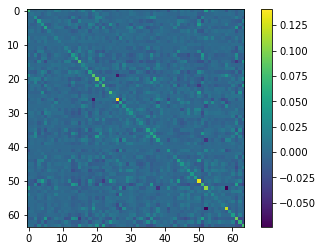

AUG[stl_1_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_05-33-59: 0.000 0.129 3.603


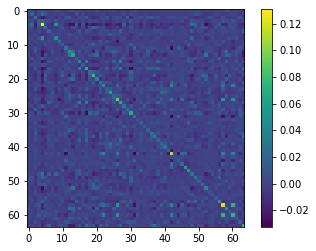

AUG[stl_1_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-15-44: 0.000 0.105 1.961


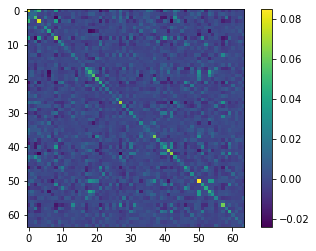

AUG[stl_2_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_06-56-34: 0.000 0.231 1.107


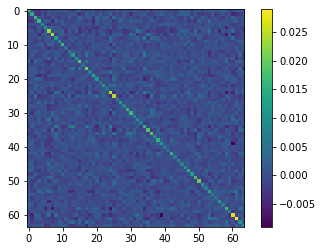

AUG[stl_2_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_07-37-11: 0.000 0.143 3.078


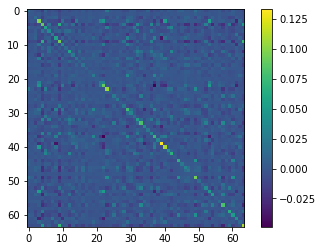

AUG[stl_2_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-18-06: 0.000 0.124 2.779


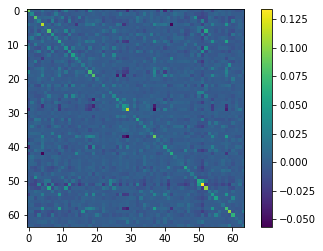

AUG[stl_2_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_08-58-56: 0.000 0.113 2.169


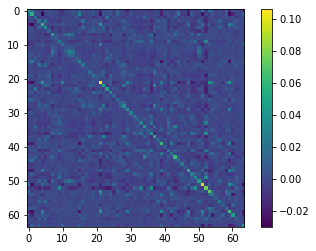

AUG[stl_2_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_09-39-44: 0.000 0.086 2.059


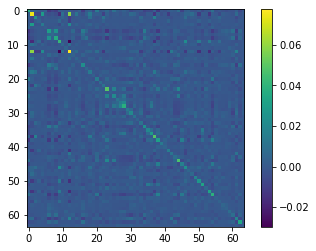

AUG[stl_3_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_10-20-56: 0.000 0.216 1.040


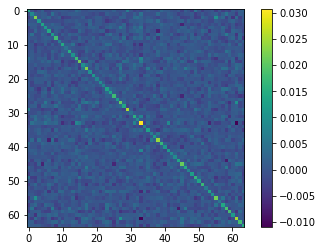

AUG[stl_3_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-01-13: 0.000 0.121 2.740


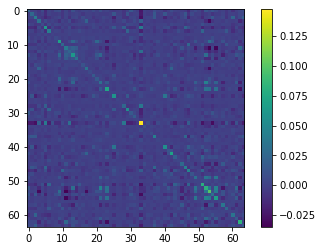

AUG[stl_3_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_11-42-15: 0.000 0.101 2.301


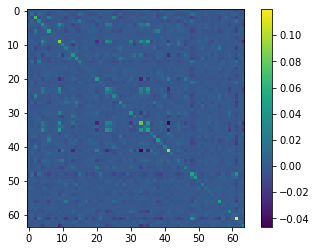

AUG[stl_3_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_12-23-33: 0.000 0.097 2.240


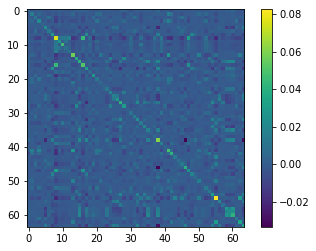

AUG[stl_3_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-04-30: 0.000 0.093 2.295


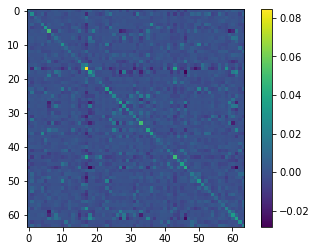

AUG[stl_4_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_13-45-46: 0.000 0.226 1.100


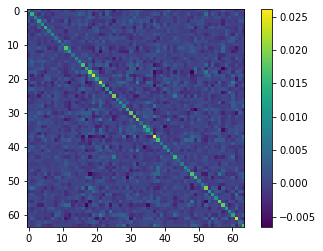

AUG[stl_4_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_14-26-14: 0.000 0.121 2.865


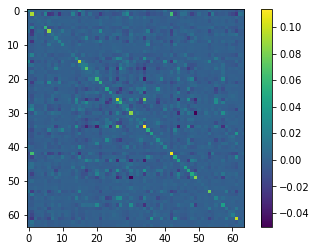

AUG[stl_4_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-07-38: 0.000 0.112 2.900


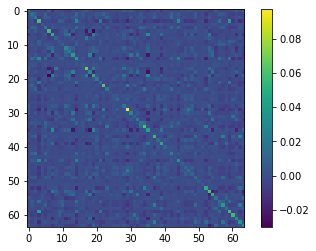

AUG[stl_4_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_15-48-38: 0.000 0.100 2.309


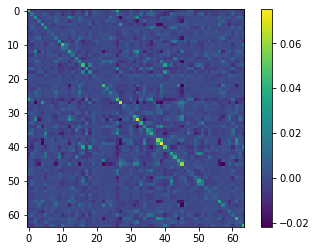

AUG[stl_4_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_16-29-54: 0.000 0.097 1.946


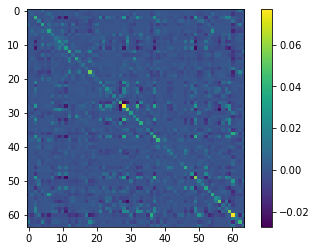

AUG[stl_5_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-10-53: 0.000 0.195 1.264


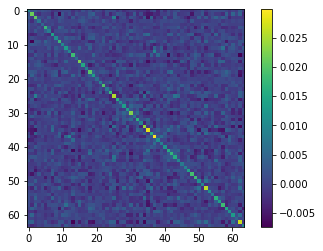

AUG[stl_5_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_17-51-38: 0.000 0.141 2.440


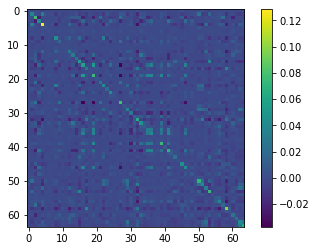

AUG[stl_5_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_18-32-48: 0.000 0.115 2.777


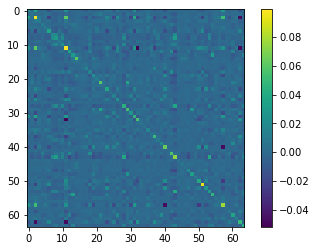

AUG[stl_5_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-14-17: 0.000 0.097 2.037


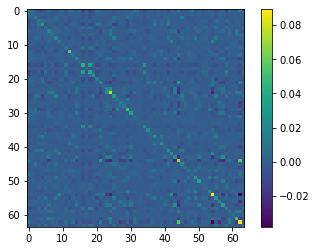

AUG[stl_5_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_19-55-23: 0.000 0.111 2.217


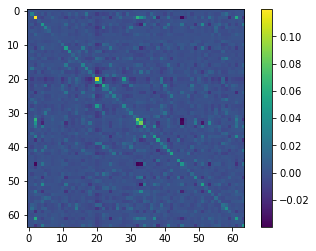

AUG[stl_6_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-11_20-36-28: 0.000 0.189 1.040


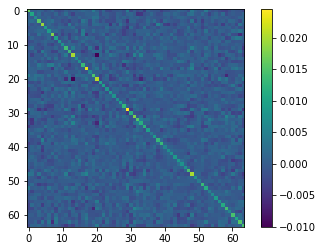

AUG[stl_6_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-17-08: 0.000 0.127 2.162


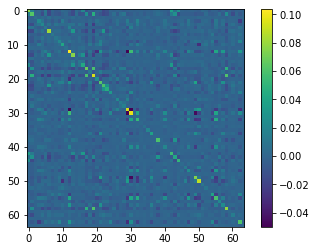

AUG[stl_6_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-11_21-58-13: 0.000 0.117 2.550


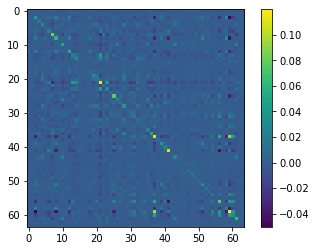

AUG[stl_6_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-11_22-39-31: 0.000 0.094 2.038


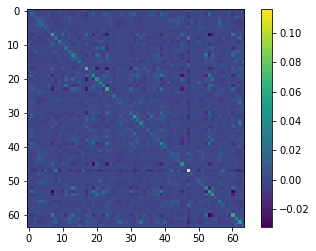

AUG[stl_6_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-11_23-20-33: 0.000 0.094 1.984


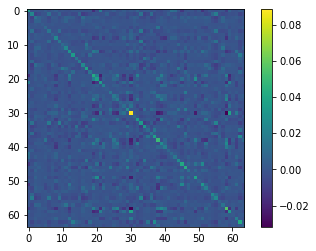

AUG[stl_7_geo_0]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-01-52: 0.000 0.218 0.981


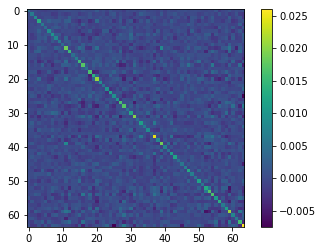

AUG[stl_7_geo_1]_BTwins_[FCN16i223o64_d_64]_2021-09-12_00-42-24: 0.000 0.128 2.068


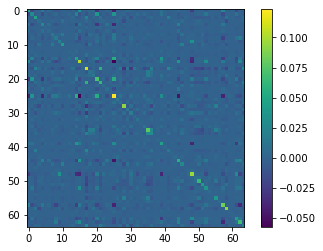

AUG[stl_7_geo_2]_BTwins_[FCN16i223o64_d_64]_2021-09-12_01-23-55: 0.000 0.107 1.760


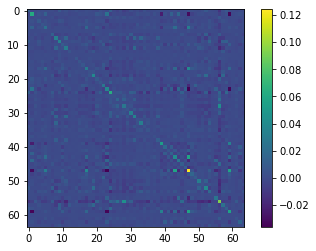

AUG[stl_7_geo_3]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-05-21: 0.000 0.107 1.646


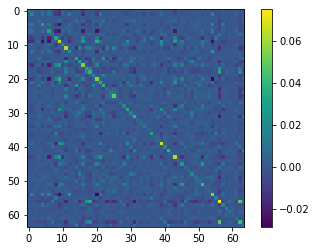

AUG[stl_7_geo_4]_BTwins_[FCN16i223o64_d_64]_2021-09-12_02-46-29: 0.000 0.106 2.056


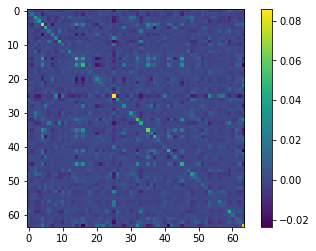

In [21]:
for p in p_experiments:
    R_train = np.load(p / "R_train.npy")
    print("{:<40}: {:.3f} {:.3f} {:.3f}".format(p.name, R_train.min(), R_train.mean(),R_train.max()))
    cov = np.cov(R_train.T)
    plt.imshow(cov)
    plt.colorbar()
    plt.show()